In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents


In [83]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/.env


True

In [84]:
%%time

from llm_toolkit.eval_openai import *
from tqdm.notebook import tqdm

tqdm.pandas()

data_path = os.getenv("DATA_PATH")
results_path = "paper/data/ollama_model_results_v3-RTX4090_Laptop.csv"
num_ctx = os.getenv("NUM_CTX")
data_path, results_path, num_ctx

CPU times: user 156 μs, sys: 43 μs, total: 199 μs
Wall time: 174 μs


('dataset/GMRID_v3.csv',
 'paper/data/ollama_model_results_v3-RTX4090_Laptop.csv',
 '8192')

In [85]:
import pandas as pd
from llm_toolkit.llm_utils import *
from llm_toolkit.data_utils import *

df = pd.read_csv(results_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147 entries, 0 to 1146
Data columns (total 80 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1147 non-null   int64  
 1   Headline                             1147 non-null   object 
 2   Details                              1147 non-null   object 
 3   Severity                             1147 non-null   object 
 4   Region                               1147 non-null   object 
 5   Datetime                             1147 non-null   object 
 6   lat                                  757 non-null    float64
 7   lon                                  757 non-null    float64
 8   maritime_label                       1147 non-null   bool   
 9   found_ports                          1147 non-null   object 
 10  contains_port_info                   1147 non-null   bool   
 11  if_labeled                    

In [86]:
model_orders = {
    k.replace("-coder", "").replace("-Coder", ""): v
    for k, v in model_orders.items()
    if "qwq" not in k.lower()
}
model_orders

{'qwen2.5:0.5b': 0.5,
 'qwen2.5:0.5b-instruct-fp16': 0.6,
 'llama3.2:1b': 1,
 'llama3.2:1b-instruct-fp16': 1.05,
 'meta-llama/Llama-3.2-1B-Instruct': 1.1,
 'qwen2.5:1.5b': 1.5,
 'qwen2.5:1.5b-instruct-fp16': 1.506,
 'Qwen/Qwen2.5-1.5B-Instruct': 1.51,
 'llama3.2:3b': 3,
 'llama3.2:3b-instruct-fp16': 3.05,
 'meta-llama/Llama-3.2-3B-Instruct': 3.1,
 'qwen2.5:3b': 4,
 'qwen2.5:3b-instruct-fp16': 4.06,
 'Qwen/Qwen2.5-3B-Instruct': 4.1,
 'microsoft/Phi-3.5-mini-instruct': 5,
 'mistralai/Mistral-7B-Instruct-v0.3': 10,
 'qwen2.5:7b': 12,
 'qwen2.5:7b-instruct-fp16': 12.05,
 'Qwen/Qwen2.5-7B-Instruct': 12.1,
 'llama3.1:8b': 15,
 'llama3.1:8b-instruct-fp16': 15.1,
 'meta-llama/Llama-3.1-8B_4bit': 16,
 'meta-llama/Llama-3.1-8B_4bit_H100': 17,
 'meta-llama/Meta-Llama-3.1-8B-Instruct': 20,
 'llama3.2-vision': 21,
 'llama3.2-vision:11b': 21,
 'llama3.2-vision:11b-instruct-fp16': 21.1,
 'meta-llama/Llama-3.2-11B-Vision-Instruct': 21.5,
 'qwen2.5:14b': 22,
 'qwen2.5:14b-instruct-fp16': 22.05,
 'Qwen/

In [87]:
result_columns = [
    col
    for col in df.columns.to_list()
    if col.split("/shots")[0] in model_orders.keys()
    and col not in ["qwen2.5:1.5b/shots-00(0.175)", "qwen2.5:1.5b/shots-01(0.162)"]
]
result_columns.sort()
result_columns = sorted(
    result_columns, key=lambda x: model_orders[x.split("/shots")[0]]
)
result_columns

['qwen2.5:0.5b/shots-00(2.709)',
 'qwen2.5:0.5b/shots-01(2.703)',
 'qwen2.5:0.5b/shots-02(2.707)',
 'qwen2.5:0.5b/shots-04(2.707)',
 'qwen2.5:0.5b/shots-08(2.711)',
 'qwen2.5:0.5b/shots-10(2.707)',
 'llama3.2:1b/shots-00(2.998)',
 'llama3.2:1b/shots-01(2.960)',
 'llama3.2:1b/shots-02(2.948)',
 'llama3.2:1b/shots-04(2.908)',
 'llama3.2:1b/shots-08(2.909)',
 'llama3.2:1b/shots-10(2.859)',
 'qwen2.5:1.5b/shots-00(2.725)',
 'qwen2.5:1.5b/shots-01(2.733)',
 'qwen2.5:1.5b/shots-02(2.735)',
 'qwen2.5:1.5b/shots-04(2.737)',
 'qwen2.5:1.5b/shots-08(2.753)',
 'qwen2.5:1.5b/shots-10(2.764)',
 'llama3.2:3b/shots-00(2.806)',
 'llama3.2:3b/shots-01(2.778)',
 'llama3.2:3b/shots-02(2.763)',
 'llama3.2:3b/shots-04(2.767)',
 'llama3.2:3b/shots-08(2.783)',
 'llama3.2:3b/shots-10(2.783)',
 'qwen2.5:3b/shots-00(2.809)',
 'qwen2.5:3b/shots-01(2.795)',
 'qwen2.5:3b/shots-02(2.798)',
 'qwen2.5:3b/shots-04(2.800)',
 'qwen2.5:3b/shots-08(2.808)',
 'qwen2.5:3b/shots-10(2.818)',
 'qwen2.5:7b/shots-00(2.969)',
 'q

In [88]:
# data_col_start_idx = 0
# result_col_start_idx = 8

data_col_start_idx = 12
result_col_start_idx = 20

In [89]:
df_results = df[
    df.columns.to_list()[data_col_start_idx:result_col_start_idx] + result_columns
]
df = df_results

In [90]:
# df_test = pd.read_csv("dataset/GMRID_v3-test.csv")
# df["gpt-4o_label"] = df_test["gpt-4o_label"]
# df.to_csv(results_path, index=False)

In [91]:
metrics_df = get_metrics(
    df,
    result_col_start_idx - data_col_start_idx,
    mean_eval_time=True,
    label_column="gpt-4o_label",
)
metrics_df

qwen2.5:0.5b/shots-00(2.709) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-00(2.709) - metrics: {'f1': 0.3908628213418354, 'accuracy': 0.3295553618134263}
Generating prompt templates for 0 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-01(2.703) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-01(2.703) - metrics: {'f1': 0.45756543830334767, 'accuracy': 0.4219703574542284}
Generating prompt templates for 1 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-02(2.707) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-02(2.707) - metrics: {'f1': 0.4351371505392214, 'accuracy': 0.43940714908456846}
Generating prompt templates for 2 shots with Headline_Details and gpt-4o_label
qwen2.5:0.5b/shots-04(2.707) - metrics_raw: {'f1': 0.0, 'accuracy': 0.0}
qwen2.5:0.5b/shots-04(2.707) - metrics: {'f1': 0.4192220732218152, 'accuracy': 0.4559721011333915}
Generating prompt templates for 4 shots with Headline_Details and gpt-4o_

model  shots  eval_time        f1  accuracy  f1_raw  \
0          qwen2.5:0.5b      0      2.709  0.390863  0.329555     0.0   
1          qwen2.5:0.5b      1      2.703  0.457565  0.421970     0.0   
2          qwen2.5:0.5b      2      2.707  0.435137  0.439407     0.0   
3          qwen2.5:0.5b      4      2.707  0.419222  0.455972     0.0   
4          qwen2.5:0.5b      8      2.711  0.442967  0.496949     0.0   
5          qwen2.5:0.5b     10      2.707  0.465777  0.503923     0.0   
6           llama3.2:1b      0      2.998  0.626531  0.576286     0.0   
7           llama3.2:1b      1      2.960  0.604593  0.606800     0.0   
8           llama3.2:1b      2      2.948  0.623562  0.604185     0.0   
9           llama3.2:1b      4      2.908  0.589856  0.573670     0.0   
10          llama3.2:1b      8      2.909  0.510236  0.530078     0.0   
11          llama3.2:1b     10      2.859  0.569839  0.591107     0.0   
12         qwen2.5:1.5b      0      2.725  0.602201  0.536181     0.0   
13         qwen2.5:1.5b      1      2.733  0.749353  0.673932     0.0   
14         qwen2.5:1.5b      2      2.735  0.726083  0.637315     0.0   
15         qwen2.5:1.5b      4      2.737  0.682741  0.593723     0.0   
16         qwen2.5:1.5b      8      2.753  0.643180  0.567568     0.0   
17         qwen2.5:1.5b     10      2.764  0.701312  0.627724     0.0   
18          llama3.2:3b      0      2.806  0.668350  0.674804     0.0   
19          llama3.2:3b      1      2.778  0.775084  0.764603     0.0   
20          llama3.2:3b      2      2.763  0.797554  0.782912     0.0   
21          llama3.2:3b      4      2.767  0.798225  0.786399     0.0   
22          llama3.2:3b      8      2.783  0.841843  0.836094     0.0   
23          llama3.2:3b     10      2.783  0.841199  0.835222     0.0   
24           qwen2.5:3b      0      2.809  0.758703  0.747167     0.0   
25           qwen2.5:3b      1      2.795  0.889259  0.868352     0.0   
26           qwen2.5:3b      2      2.798  0.888523  0.863993     0.0   
27           qwen2.5:3b      4      2.800  0.895319  0.870096     0.0   
28           qwen2.5:3b      8      2.808  0.906474  0.884917     0.0   
29           qwen2.5:3b     10      2.818  0.903311  0.882302     0.0   
30           qwen2.5:7b      0      2.969  0.898423  0.894507     0.0   
31           qwen2.5:7b      1      2.920  0.915120  0.900610     0.0   
32           qwen2.5:7b      2      2.952  0.921890  0.916303     0.0   
33           qwen2.5:7b      4      2.965  0.917168  0.910201     0.0   
34           qwen2.5:7b      8      2.987  0.912820  0.903226     0.0   
35           qwen2.5:7b     10      2.983  0.924557  0.918047     0.0   
36          llama3.1:8b      0      3.023  0.741354  0.753269     0.0   
37          llama3.1:8b      1      2.931  0.907185  0.904098     0.0   
38          llama3.1:8b      2      2.950  0.884689  0.884045     0.0   
39          llama3.1:8b      4      2.949  0.922125  0.920663     0.0   
40          llama3.1:8b      8      2.933  0.920710  0.919791     0.0   
41          llama3.1:8b     10      2.959  0.931879  0.931997     0.0   
42  llama3.2-vision:11b      0      3.014  0.733101  0.747167     0.0   
43  llama3.2-vision:11b      1      2.928  0.893035  0.890148     0.0   
44  llama3.2-vision:11b      2      2.941  0.875567  0.875327     0.0   
45  llama3.2-vision:11b      4      2.949  0.916758  0.915432     0.0   
46  llama3.2-vision:11b      8      2.946  0.917607  0.916303     0.0   
47  llama3.2-vision:11b     10      2.956  0.933914  0.933740     0.0   
48          qwen2.5:14b      0      3.300  0.890468  0.888405     0.0   
49          qwen2.5:14b      1      3.259  0.944332  0.939843     0.0   
50          qwen2.5:14b      2      3.272  0.942376  0.939843     0.0   
51          qwen2.5:14b      4      3.264  0.930303  0.925894     0.0   
52          qwen2.5:14b      8      3.281  0.939500  0.937228     0.0   
53          qwen2.5:14b     10      3.292  0.950879  0.947690     0.0   
54 

In [92]:
models = metrics_df["model"].unique()
models

array(['qwen2.5:0.5b', 'llama3.2:1b', 'qwen2.5:1.5b', 'llama3.2:3b',
       'qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b', 'llama3.2-vision:11b',
       'qwen2.5:14b', 'qwen2.5:32b'], dtype=object)

In [93]:
all_models = models.tolist()
models = [x for x in all_models if "fp16" not in x.lower()]
llama_models = [x for x in models if "llama" in x.lower()]
qwen_models = [x for x in models if "qw" in x.lower()]
llama_models, qwen_models

(['llama3.2:1b', 'llama3.2:3b', 'llama3.1:8b', 'llama3.2-vision:11b'],
 ['qwen2.5:0.5b',
  'qwen2.5:1.5b',
  'qwen2.5:3b',
  'qwen2.5:7b',
  'qwen2.5:14b',
  'qwen2.5:32b'])

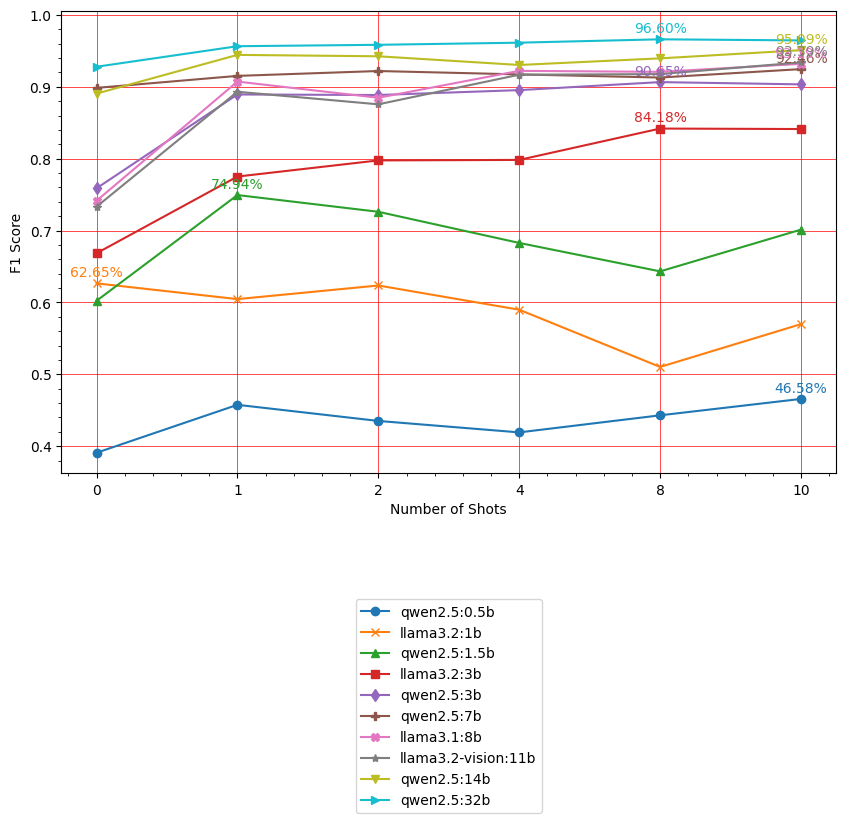

In [94]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.75),
)

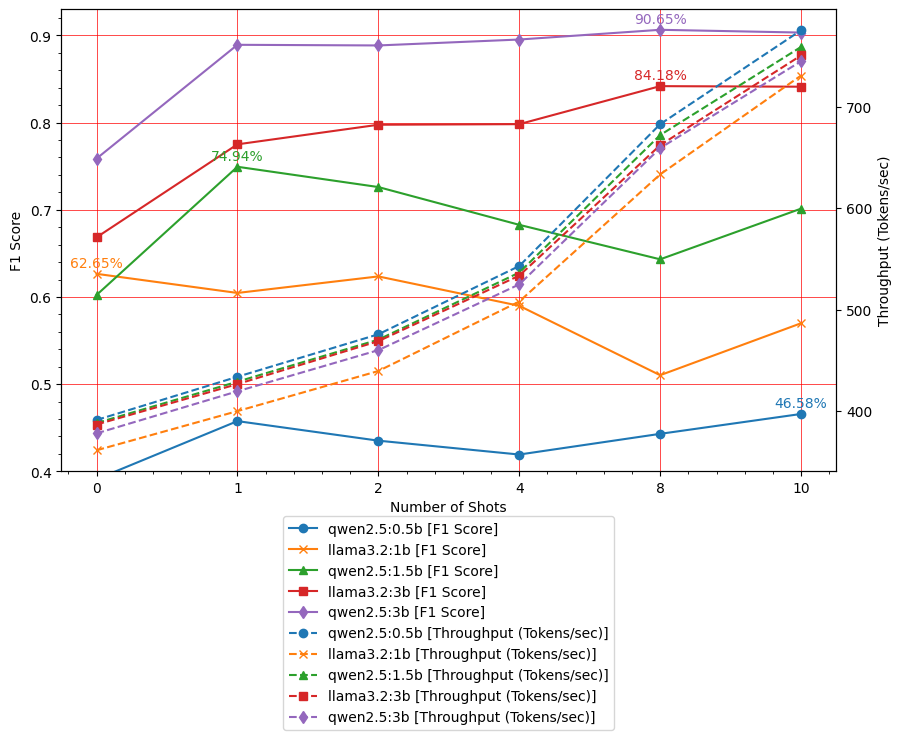

In [95]:
plot_metrics_vs_shots(
    metrics_df,
    models[:5],
    markers[:5],
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    ylimits=(0.4, 0.92),
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.575),
)

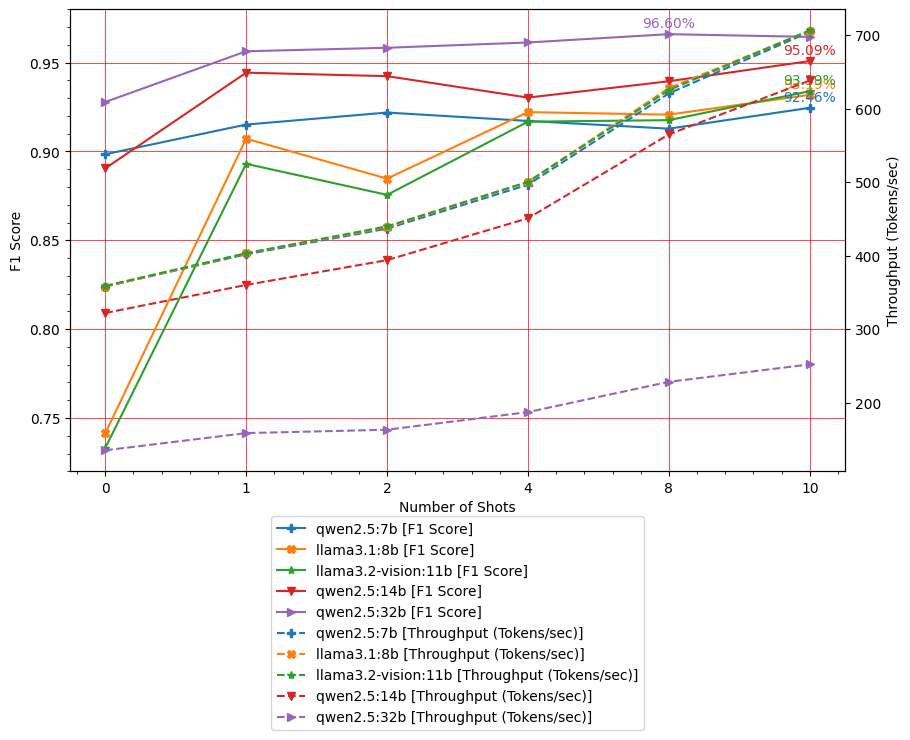

In [96]:
plot_metrics_vs_shots(
    metrics_df,
    models[5:10],
    markers[5:10],
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    ylimits=(0.72, 0.97),
    # log_scales=[False, True],
    bbox_to_anchor=(0.5, -0.575),
)

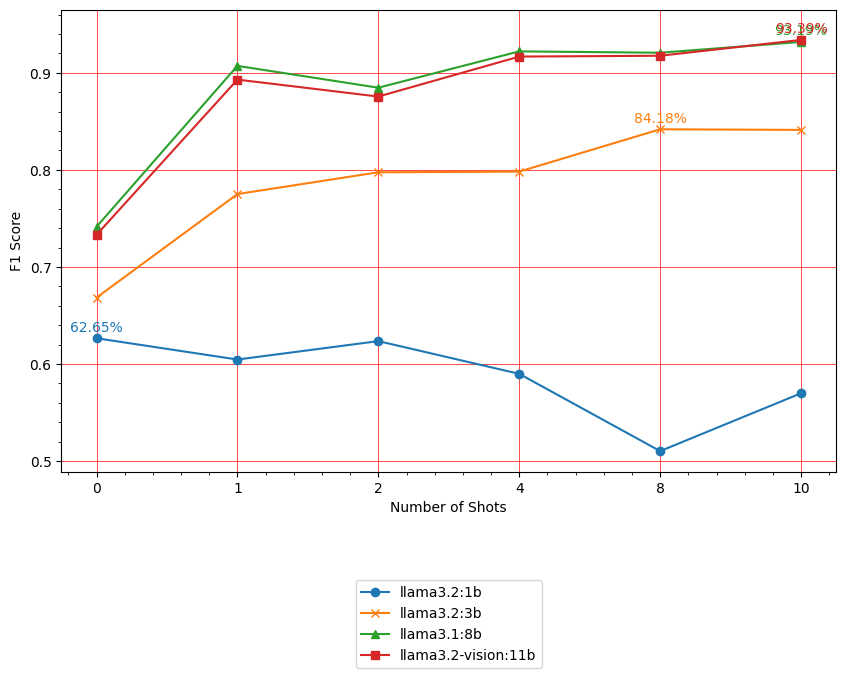

In [98]:
plot_metrics_vs_shots(
    metrics_df,
    llama_models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.44),
)

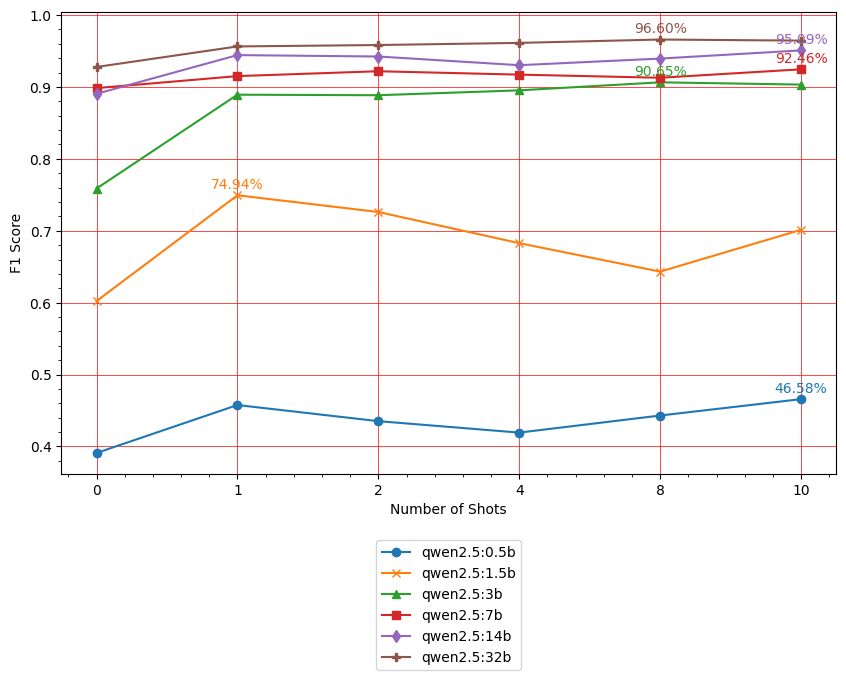

In [99]:
plot_metrics_vs_shots(
    metrics_df,
    qwen_models,
    markers,
    ["f1"],
    ["F1 Score"],
    bbox_to_anchor=(0.5, -0.44),
)

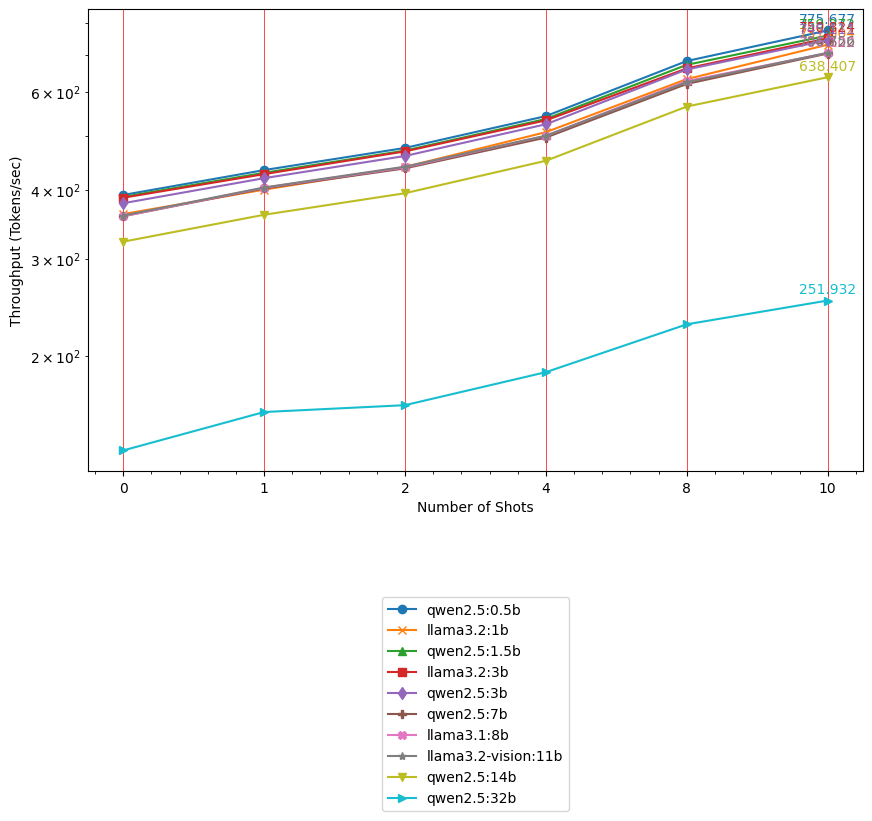

In [100]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    use_percentage=False,
)

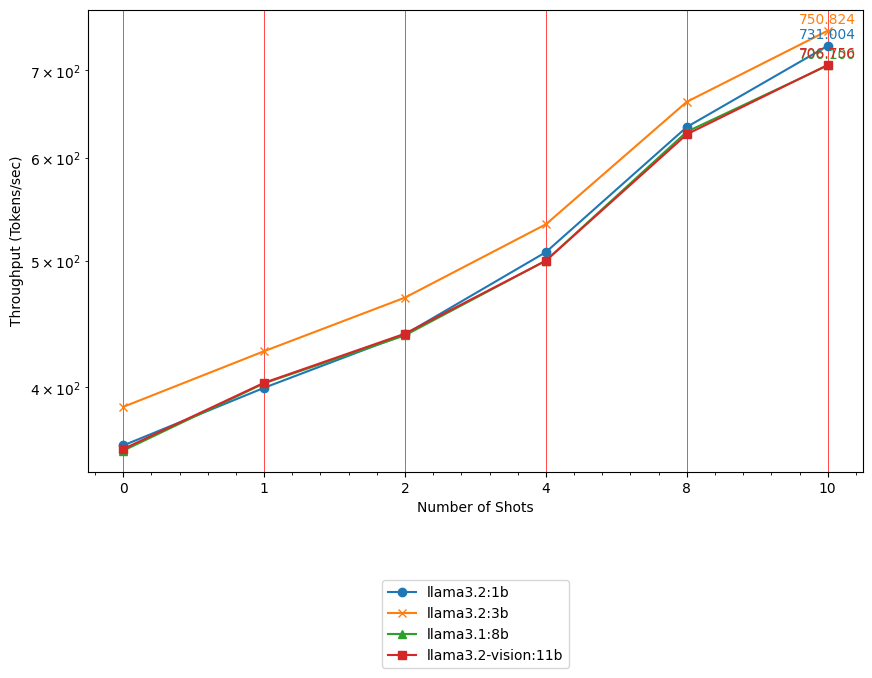

In [101]:
plot_metrics_vs_shots(
    metrics_df,
    llama_models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.44),
    use_percentage=False,
)

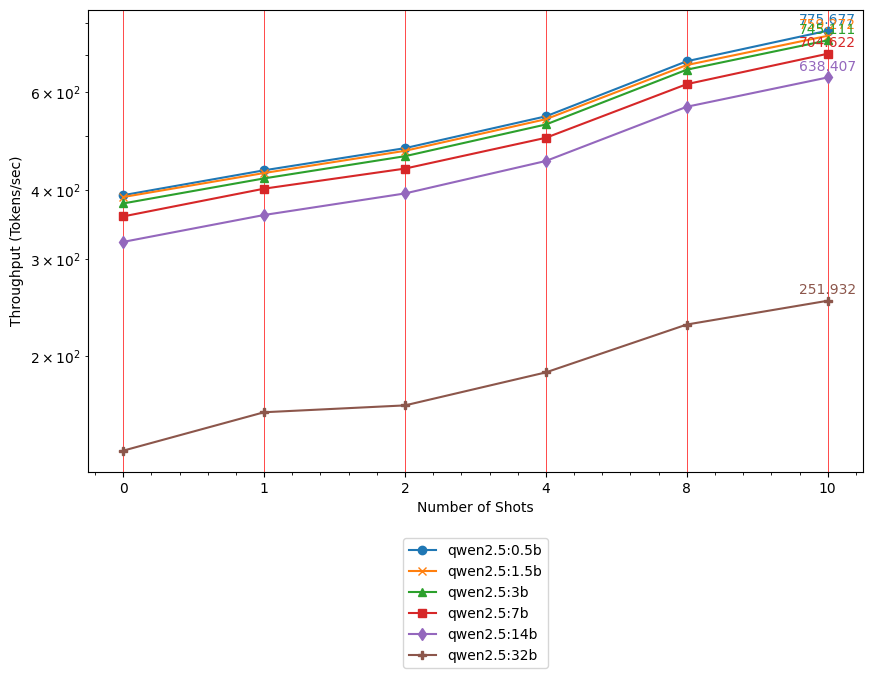

In [102]:
plot_metrics_vs_shots(
    metrics_df,
    qwen_models,
    markers,
    ["eval_speed"],
    ["Throughput (Tokens/sec)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.44),
    use_percentage=False,
)

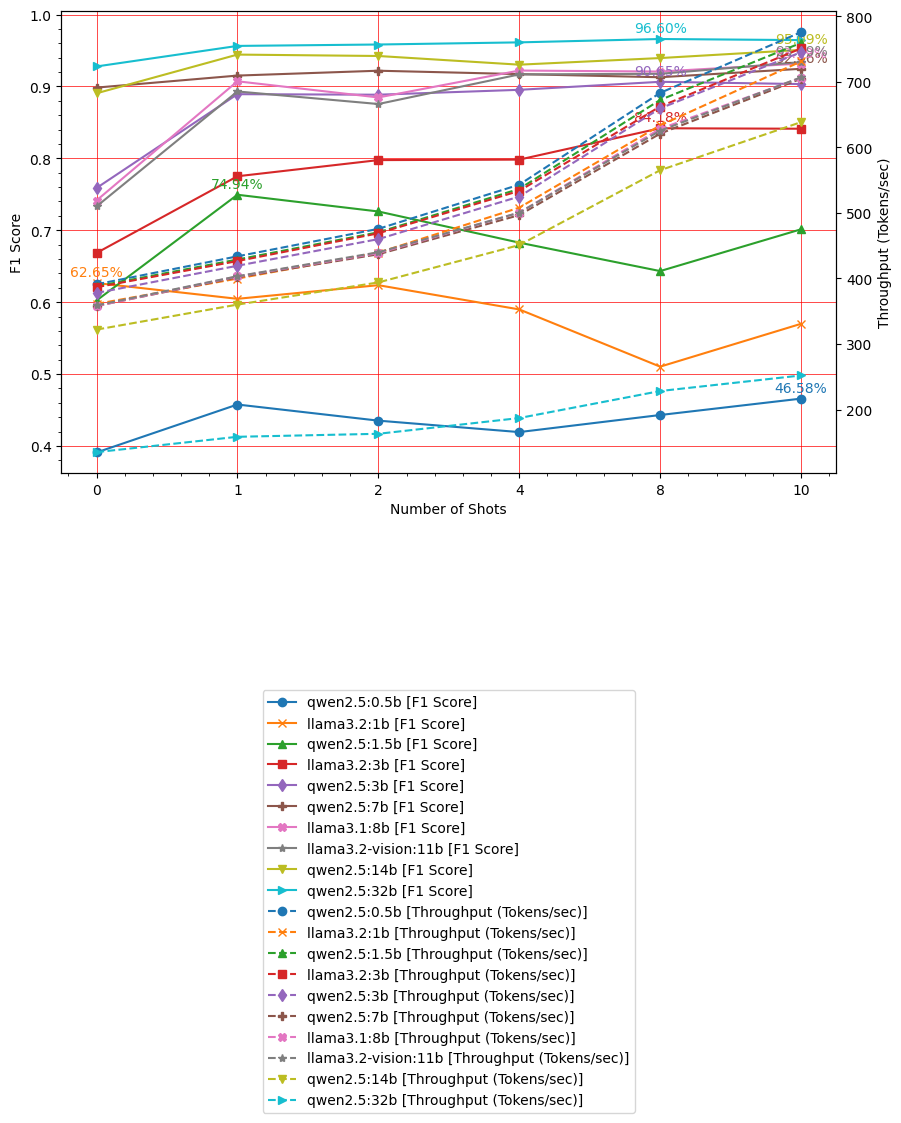

In [103]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["f1", "eval_speed"],
    ["F1 Score", "Throughput (Tokens/sec)"],
    bbox_to_anchor=(0.5, -1.4),
)

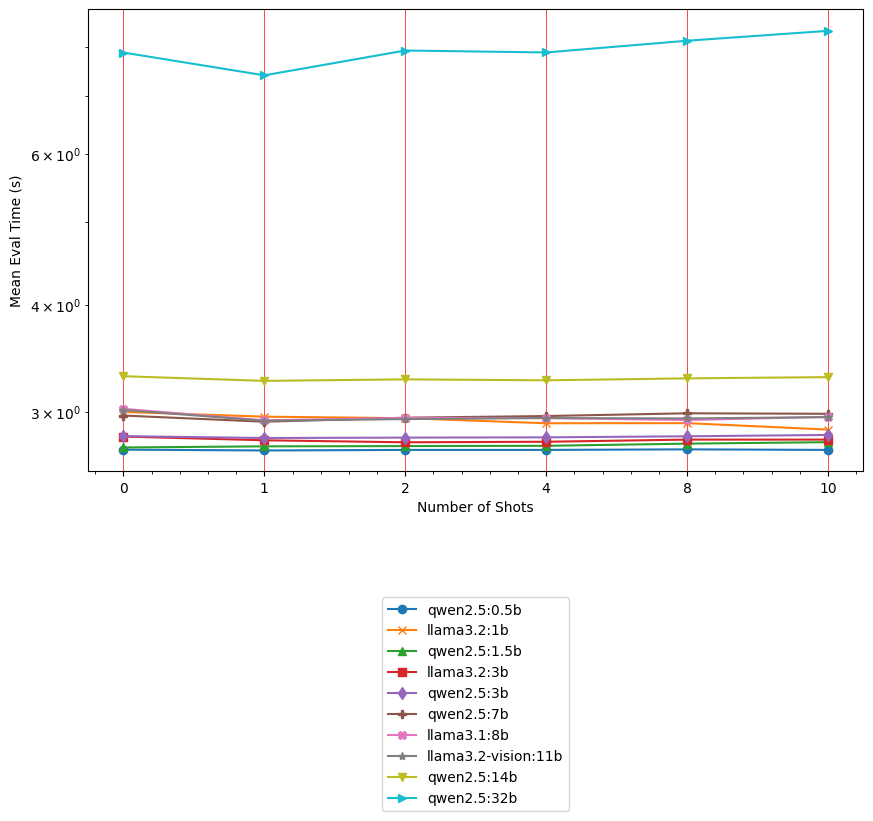

In [104]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["eval_time"],
    ["Mean Eval Time (s)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    use_percentage=False,
    add_values=False,
)

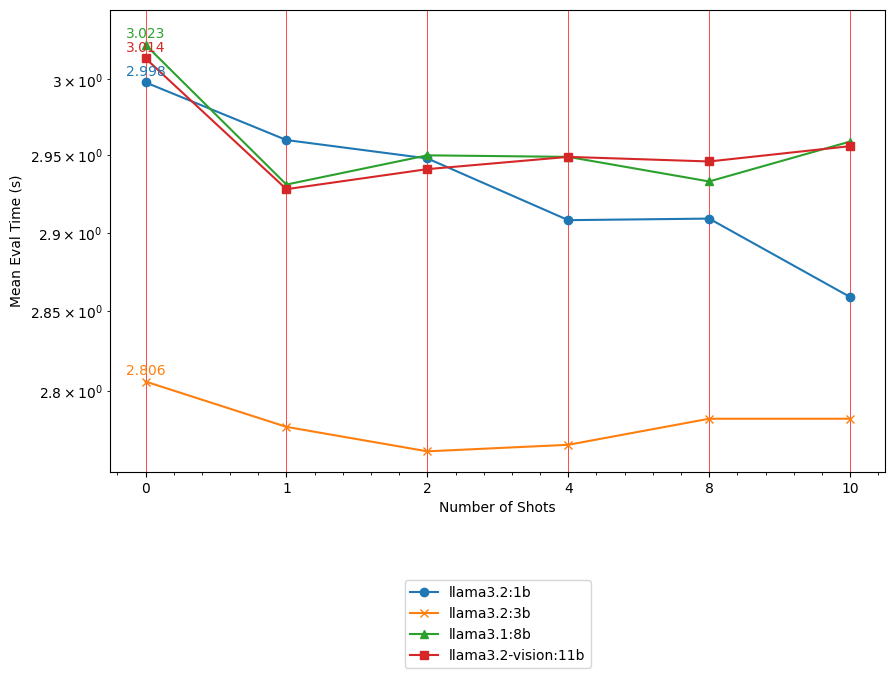

In [105]:
plot_metrics_vs_shots(
    metrics_df,
    llama_models,
    markers,
    ["eval_time"],
    ["Mean Eval Time (s)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.44),
    use_percentage=False,
)

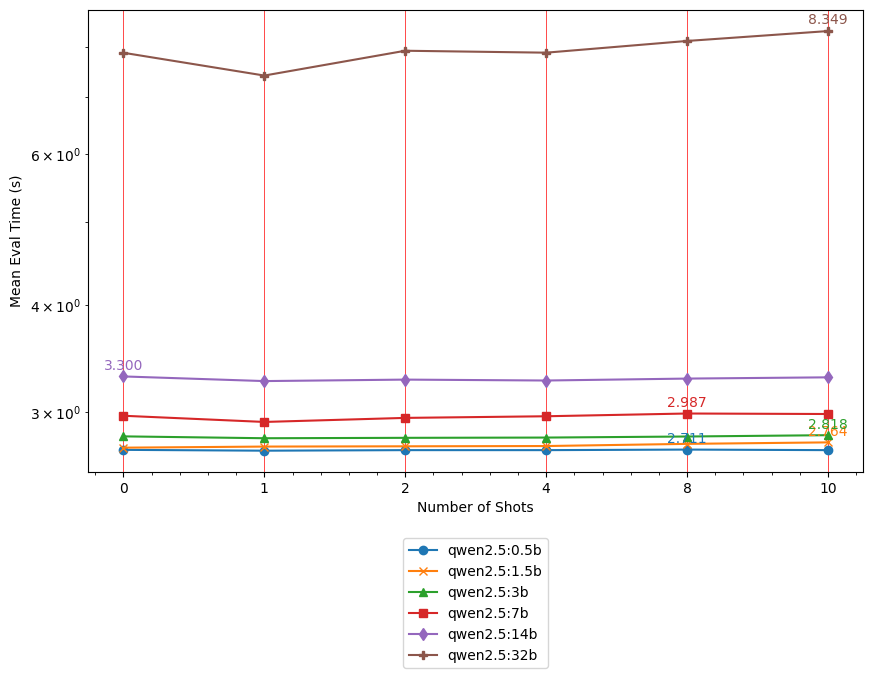

In [106]:
plot_metrics_vs_shots(
    metrics_df,
    qwen_models,
    markers,
    ["eval_time"],
    ["Mean Eval Time (s)"],
    log_scales=[True],
    bbox_to_anchor=(0.5, -0.44),
    use_percentage=False,
)

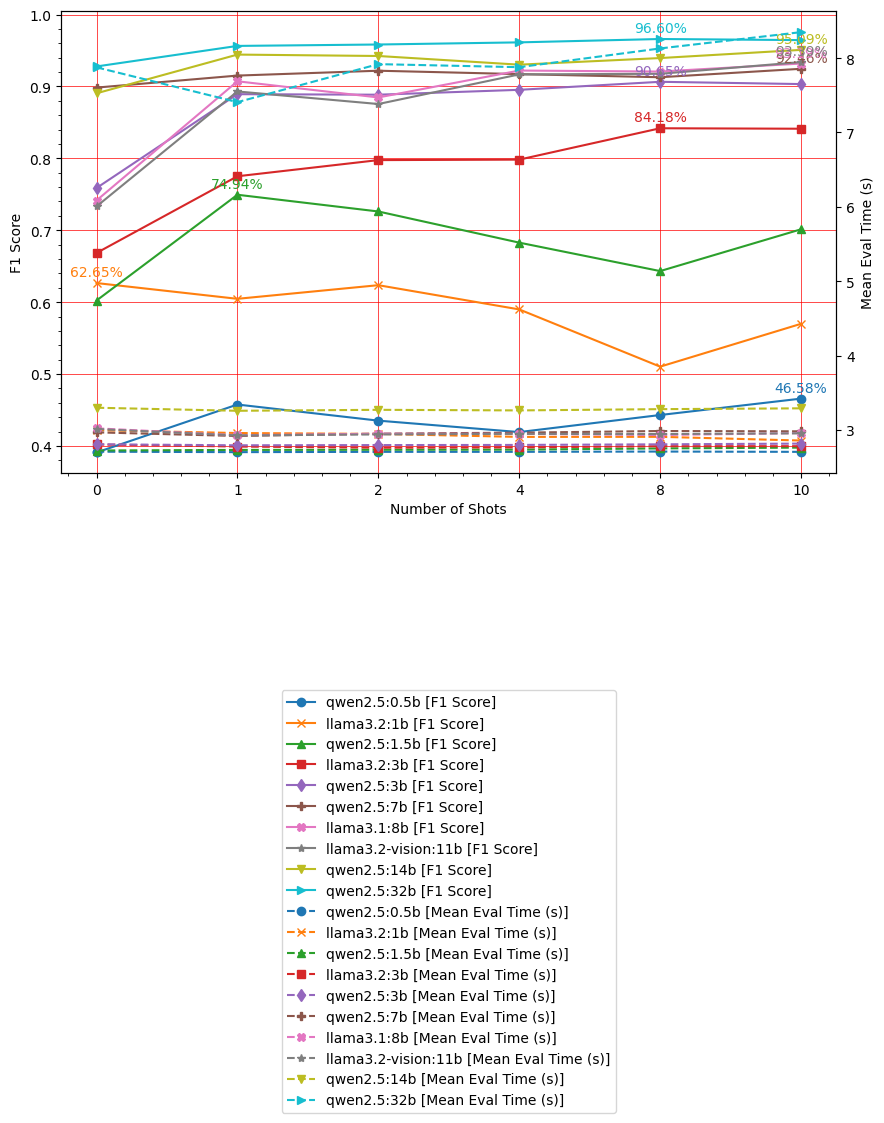

In [107]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["f1", "eval_time"],
    ["F1 Score", "Mean Eval Time (s)"],
    bbox_to_anchor=(0.5, -1.4),
)

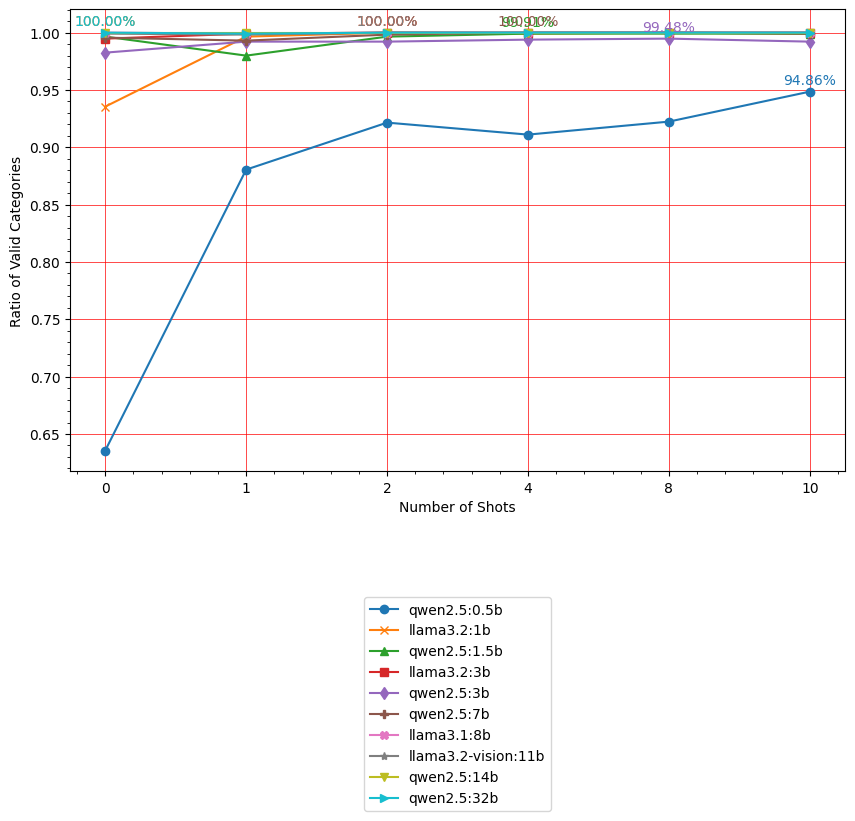

In [108]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["ratio_valid_categories"],
    ["Ratio of Valid Categories"],
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    ylimits_offset=0.002,
)

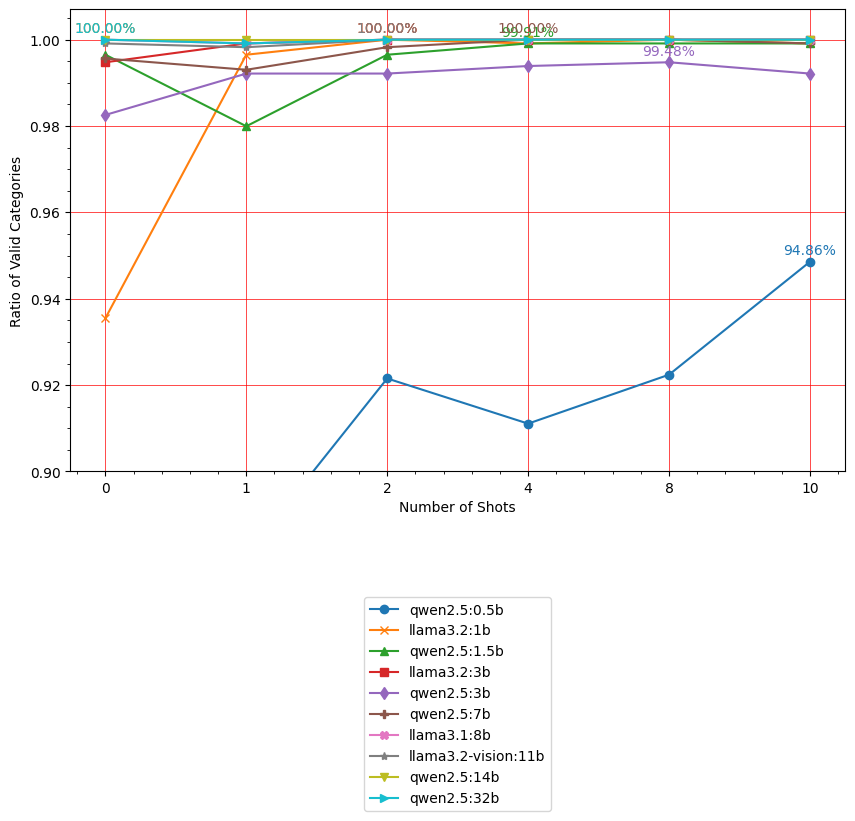

In [109]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["ratio_valid_categories"],
    ["Ratio of Valid Categories"],
    # log_scales=[True],
    bbox_to_anchor=(0.5, -0.75),
    ylimits=[0.9, 1.005],
    ylimits_offset=0.002,
)

In [110]:
top_metrics_df = get_top_metrics_df(metrics_df)
top_metrics_df

model  shots  eval_time        f1  accuracy  f1_raw  \
5          qwen2.5:0.5b     10      2.707  0.465777  0.503923     0.0   
6           llama3.2:1b      0      2.998  0.626531  0.576286     0.0   
13         qwen2.5:1.5b      1      2.733  0.749353  0.673932     0.0   
22          llama3.2:3b      8      2.783  0.841843  0.836094     0.0   
28           qwen2.5:3b      8      2.808  0.906474  0.884917     0.0   
35           qwen2.5:7b     10      2.983  0.924557  0.918047     0.0   
41          llama3.1:8b     10      2.959  0.931879  0.931997     0.0   
47  llama3.2-vision:11b     10      2.956  0.933914  0.933740     0.0   
53          qwen2.5:14b     10      3.292  0.950879  0.947690     0.0   
58          qwen2.5:32b      8      8.130  0.966002  0.965126     0.0   

    accuracy_raw  ratio_valid_categories  total_tokens  eval_speed  
5            0.0                0.948561       2408422  775.676996  
6            0.0                0.935484       1241676  361.088154  
13           0.0                0.979948       1344181  428.799927  
22           0.0                1.000000       2113953  662.245023  
28           0.0                0.994769       2123716  659.380224  
35           0.0                0.999128       2410865  704.622036  
41           0.0                1.000000       2396483  706.099607  
47           0.0                1.000000       2396280  706.756344  
53           0.0                1.000000       2410575  638.406652  
58           0.0                1.000000       2127910  228.191410

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


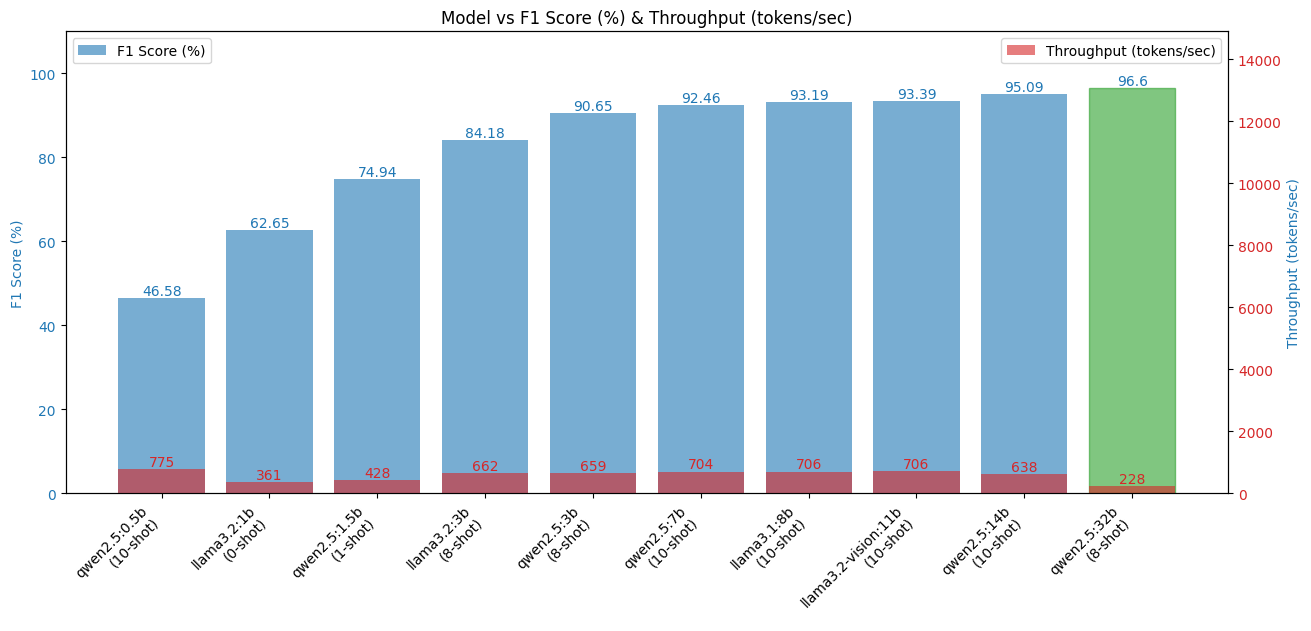

In [111]:
plot_metrics_bar_charts(top_metrics_df, second_ylim=[0, 14900])

/Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py:1136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['model'], rotation=45, ha='right')


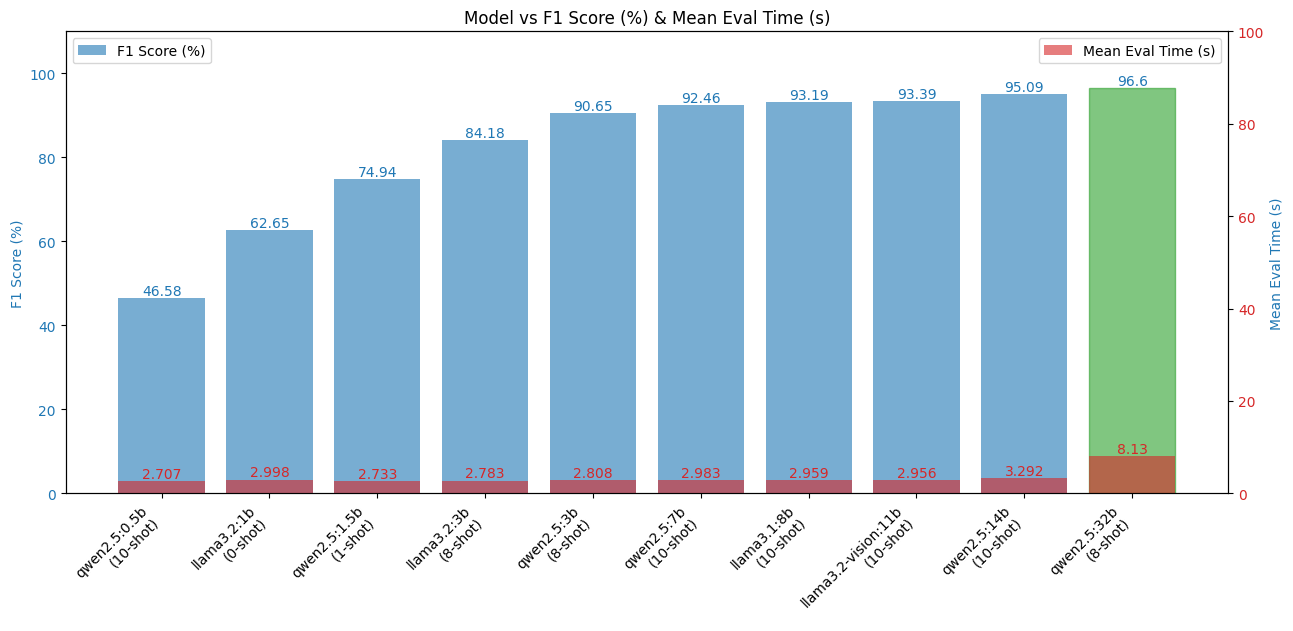

In [112]:
plot_metrics_bar_charts(
    top_metrics_df,
    second_column="eval_time",
    second_title="Mean Eval Time (s)",
    second_ylim=(0, 100),
    second_decimals=3,
)

In [113]:
ensemble_models = [
    m
    for m in all_models
    if "fp" not in m
    and top_metrics_df[top_metrics_df["model"] == m].iloc[0]["f1"] >= 0.9
]
ensemble_models

['qwen2.5:3b',
 'qwen2.5:7b',
 'llama3.1:8b',
 'llama3.2-vision:11b',
 'qwen2.5:14b',
 'qwen2.5:32b']

In [114]:
ensemble_models = ensemble_models[:5]
ensemble_models

['qwen2.5:3b',
 'qwen2.5:7b',
 'llama3.1:8b',
 'llama3.2-vision:11b',
 'qwen2.5:14b']

In [115]:
def majority_vote(v1, v2, v3):
    v1_ans, v2_ans, v3_ans = extract_answer(v1), extract_answer(v2), extract_answer(v3)
    if v2_ans == v3_ans and v3_ans != v1_ans:
        return v2

    return v1

In [116]:
import itertools

permutations = list(itertools.combinations(ensemble_models, 3))

for perm in permutations:
    print(perm)

('qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b')
('qwen2.5:3b', 'qwen2.5:7b', 'llama3.2-vision:11b')
('qwen2.5:3b', 'qwen2.5:7b', 'qwen2.5:14b')
('qwen2.5:3b', 'llama3.1:8b', 'llama3.2-vision:11b')
('qwen2.5:3b', 'llama3.1:8b', 'qwen2.5:14b')
('qwen2.5:3b', 'llama3.2-vision:11b', 'qwen2.5:14b')
('qwen2.5:7b', 'llama3.1:8b', 'llama3.2-vision:11b')
('qwen2.5:7b', 'llama3.1:8b', 'qwen2.5:14b')
('qwen2.5:7b', 'llama3.2-vision:11b', 'qwen2.5:14b')
('llama3.1:8b', 'llama3.2-vision:11b', 'qwen2.5:14b')


In [117]:
for perm in permutations:
    print(perm)
    selected_rows = top_metrics_df[top_metrics_df["model"].isin(perm)]
    selected_rows = selected_rows.sort_values(by="f1", ascending=False)

    columns = []
    shots = 0
    eval_time = 0
    title = None
    for idx, row in selected_rows.iterrows():
        columns.append(
            f"{row['model']}/shots-{row['shots']:02d}({row['eval_time']:.3f})"
        )
        shots += row["shots"]
        eval_time += row["eval_time"]
        if title:
            title += f"_{row['model']}"
        else:
            title = row["model"]

    print(title, eval_time, columns)

    df_results[f"{title}/shots-{shots}({eval_time:.3f})"] = df_results.apply(
        lambda x: majority_vote(x[columns[0]], x[columns[1]], x[columns[2]]), axis=1
    )

('qwen2.5:3b', 'qwen2.5:7b', 'llama3.1:8b')
llama3.1:8b_qwen2.5:7b_qwen2.5:3b 8.75 ['llama3.1:8b/shots-10(2.959)', 'qwen2.5:7b/shots-10(2.983)', 'qwen2.5:3b/shots-08(2.808)']
('qwen2.5:3b', 'qwen2.5:7b', 'llama3.2-vision:11b')
llama3.2-vision:11b_qwen2.5:7b_qwen2.5:3b 8.747 ['llama3.2-vision:11b/shots-10(2.956)', 'qwen2.5:7b/shots-10(2.983)', 'qwen2.5:3b/shots-08(2.808)']
('qwen2.5:3b', 'qwen2.5:7b', 'qwen2.5:14b')
qwen2.5:14b_qwen2.5:7b_qwen2.5:3b 9.083 ['qwen2.5:14b/shots-10(3.292)', 'qwen2.5:7b/shots-10(2.983)', 'qwen2.5:3b/shots-08(2.808)']
('qwen2.5:3b', 'llama3.1:8b', 'llama3.2-vision:11b')
llama3.2-vision:11b_llama3.1:8b_qwen2.5:3b 8.722999999999999 ['llama3.2-vision:11b/shots-10(2.956)', 'llama3.1:8b/shots-10(2.959)', 'qwen2.5:3b/shots-08(2.808)']
('qwen2.5:3b', 'llama3.1:8b', 'qwen2.5:14b')
qwen2.5:14b_llama3.1:8b_qwen2.5:3b 9.059 ['qwen2.5:14b/shots-10(3.292)', 'llama3.1:8b/shots-10(2.959)', 'qwen2.5:3b/shots-08(2.808)']
('qwen2.5:3b', 'llama3.2-vision:11b', 'qwen2.5:14b')
qw

In [118]:
top_metrics_df.describe()

shots  eval_time         f1   accuracy  f1_raw  accuracy_raw  \
count  10.000000  10.000000  10.000000  10.000000    10.0          10.0   
mean    7.500000   3.434900   0.829721   0.817175     0.0           0.0   
std     3.807887   1.658506   0.166592   0.169145     0.0           0.0   
min     0.000000   2.707000   0.465777   0.503923     0.0           0.0   
25%     8.000000   2.789250   0.772475   0.714473     0.0           0.0   
50%     9.000000   2.957500   0.915515   0.901482     0.0           0.0   
75%    10.000000   2.994250   0.933405   0.933304     0.0           0.0   
max    10.000000   8.130000   0.966002   0.965126     0.0           0.0   

       ratio_valid_categories  total_tokens  eval_speed  
count               10.000000  1.000000e+01   10.000000  
mean                 0.985789  2.097406e+06  587.126637  
std                  0.024081  4.438910e+05  181.448026  
min                  0.935484  1.241676e+06  228.191410  
25%                  0.983653  2.116394e+06  481.201608  
50%                  0.999564  2.262095e+06  660.812623  
75%                  1.000000  2.405437e+06  705.730214  
max                  1.000000  2.410865e+06  775.676996

In [119]:
metrics_df.to_csv(results_path.replace(".csv", "_metrics.csv"), index=False)
top_metrics_df.to_csv(results_path.replace(".csv", "_top_metrics.csv"), index=False)

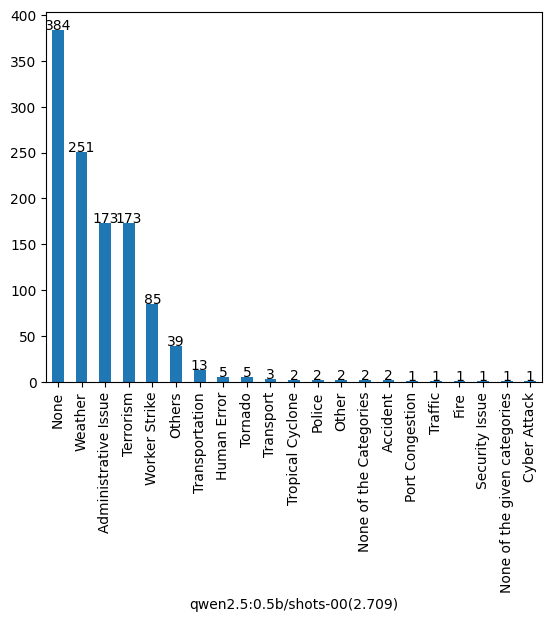

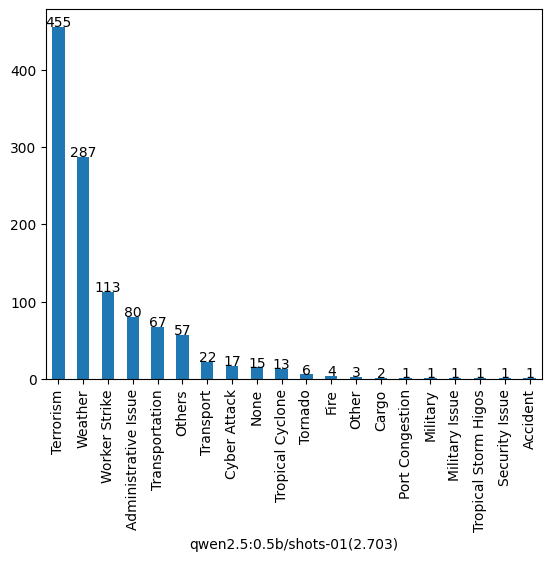

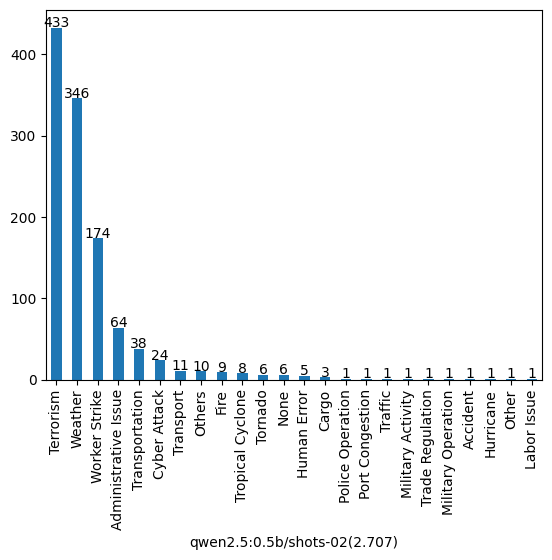

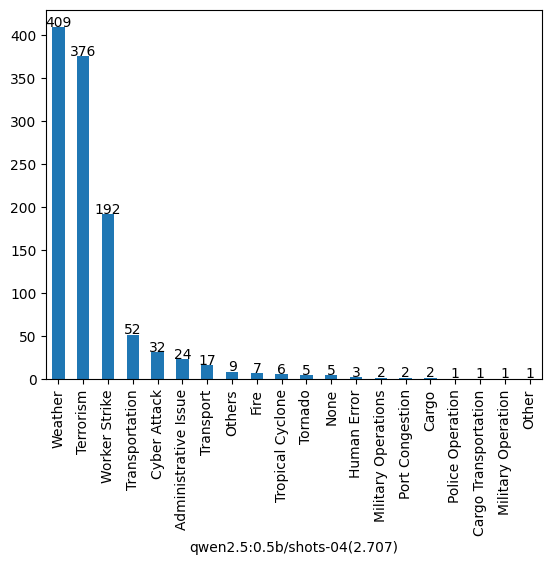

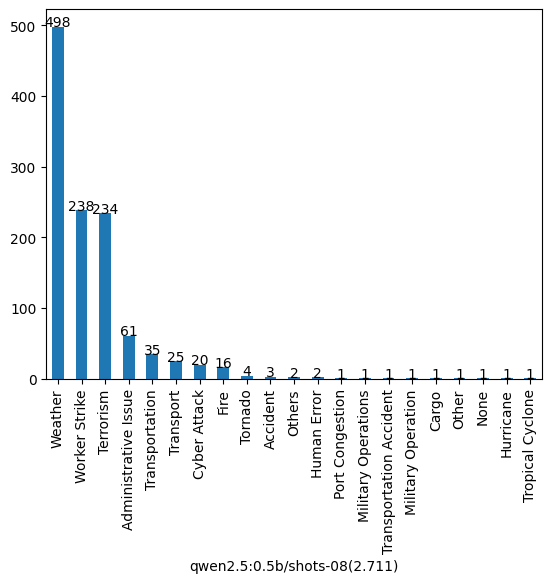

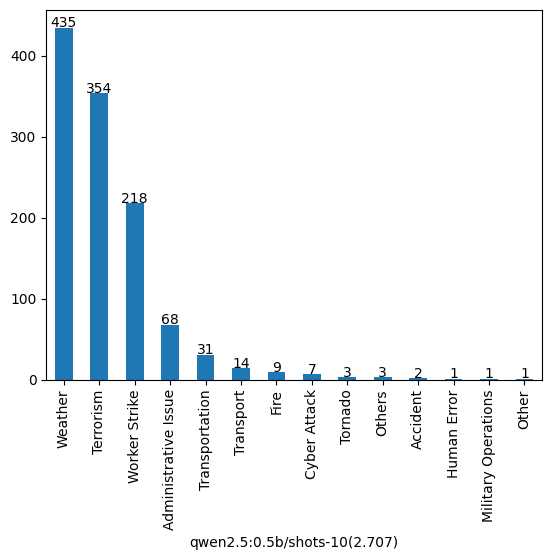

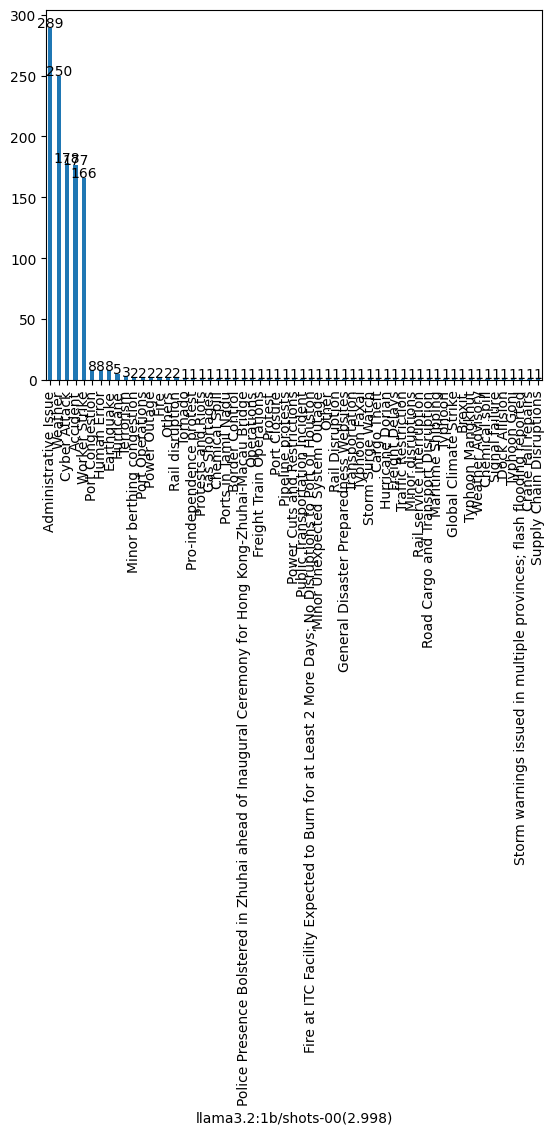

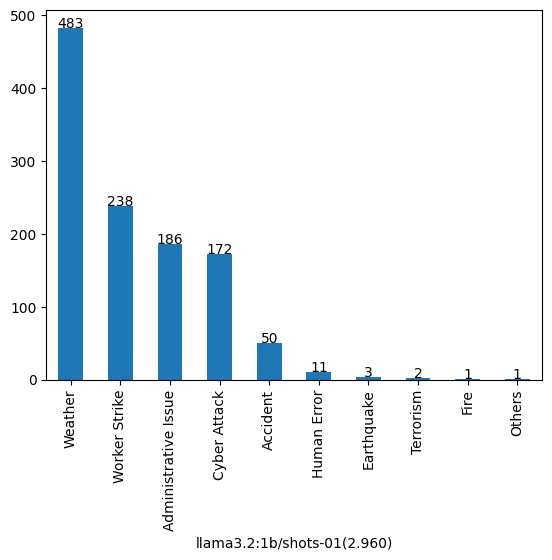

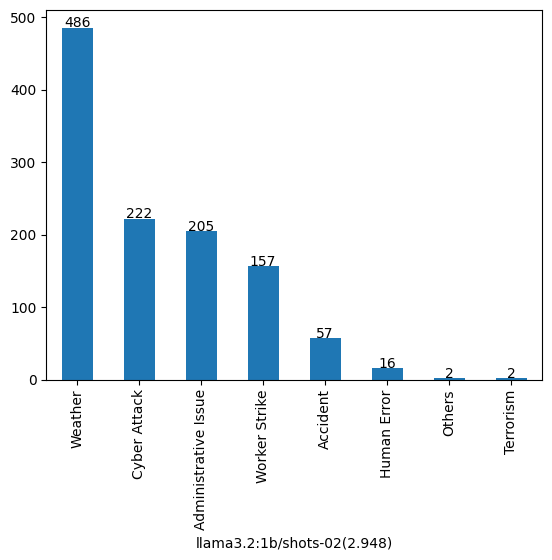

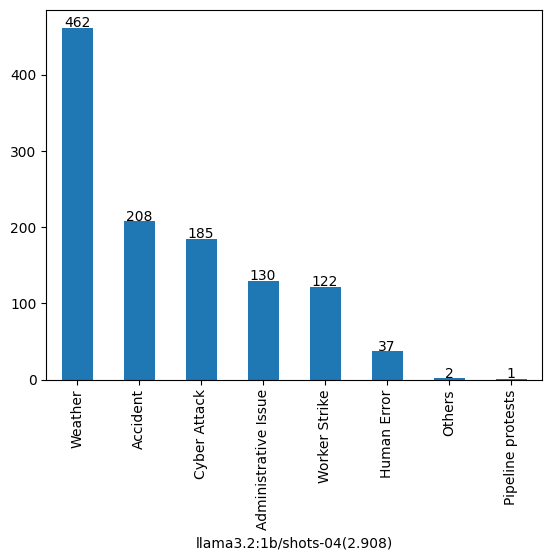

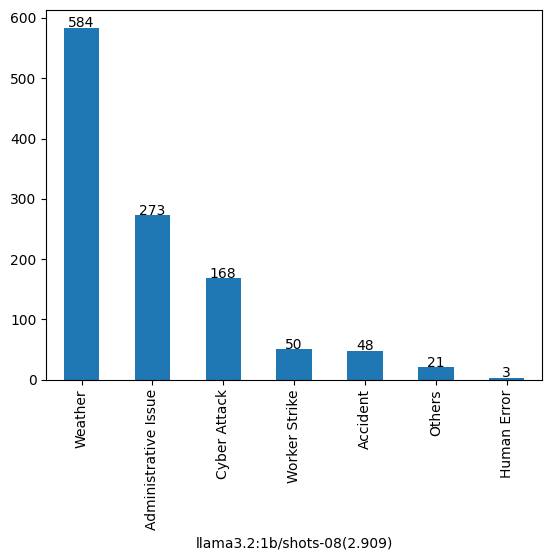

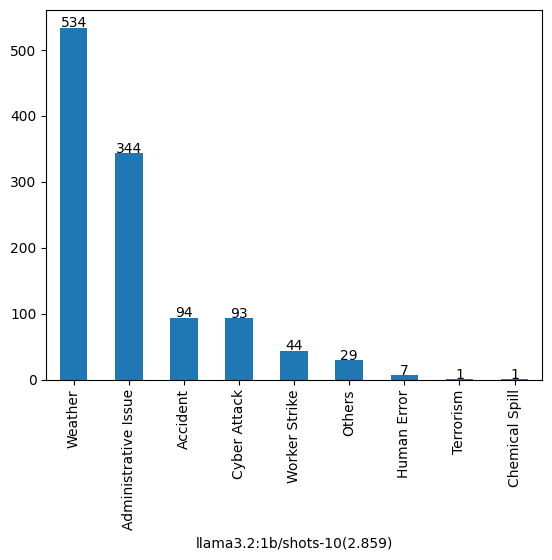

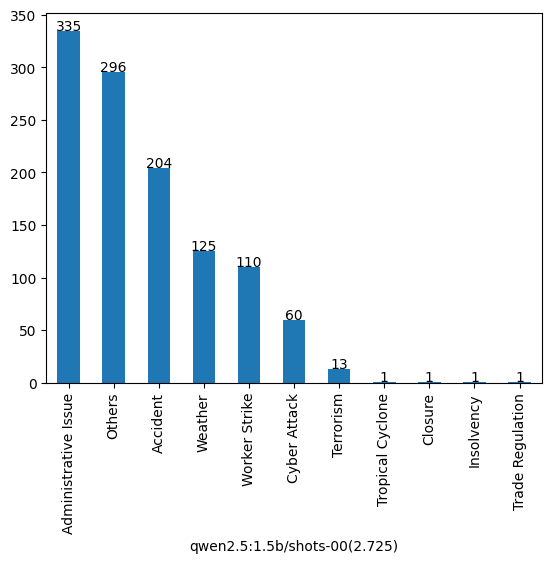

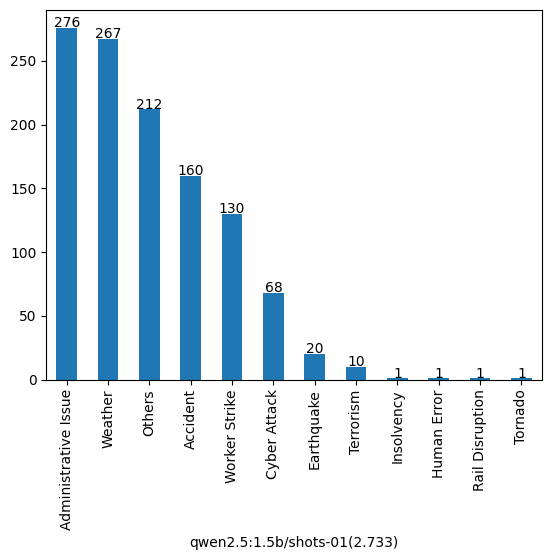

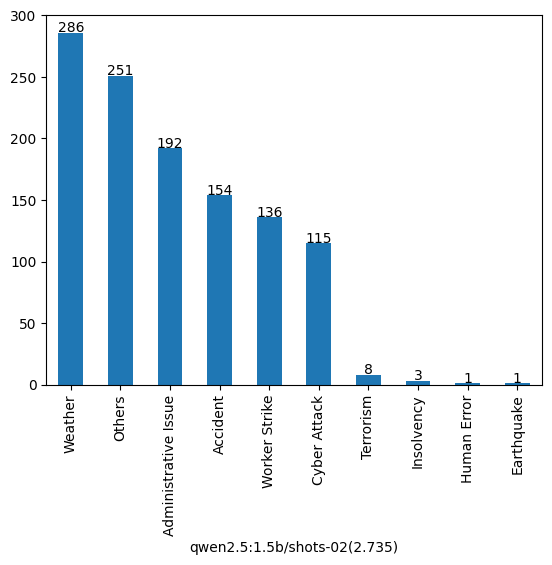

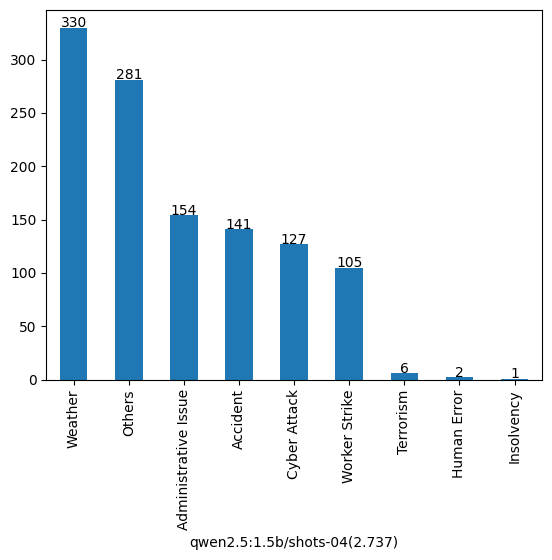

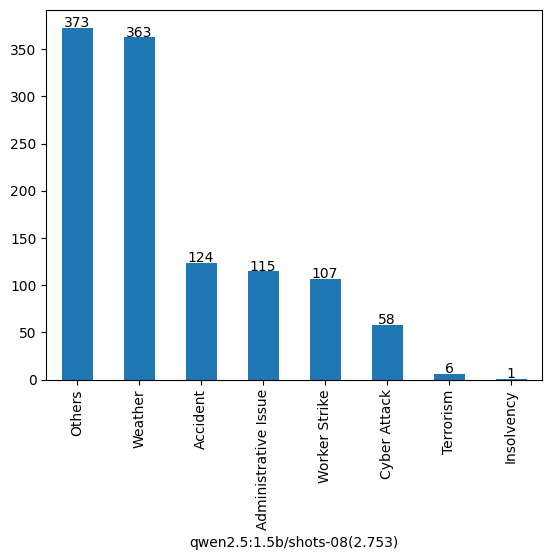

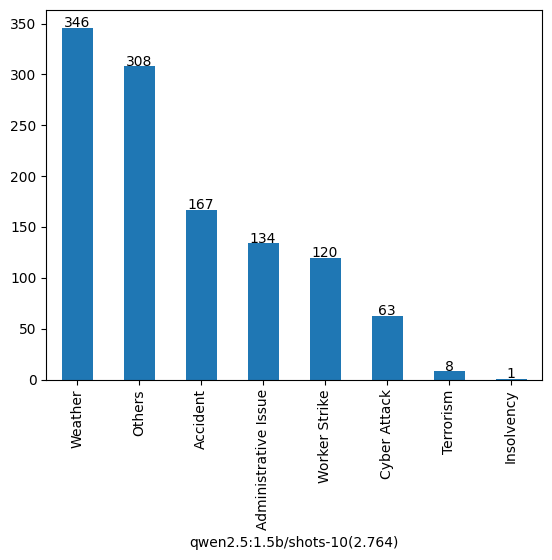

category not in json: {}


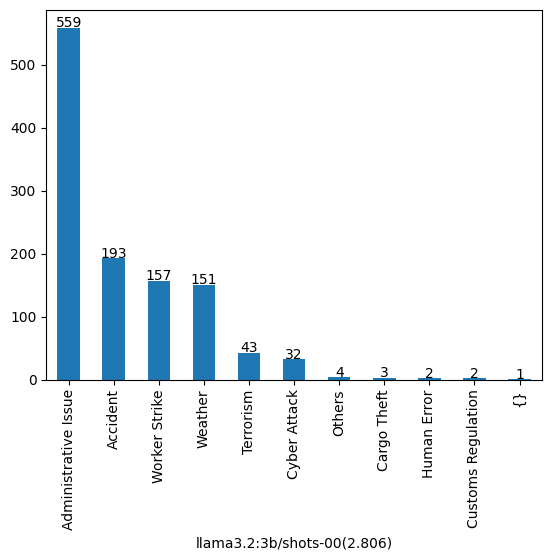

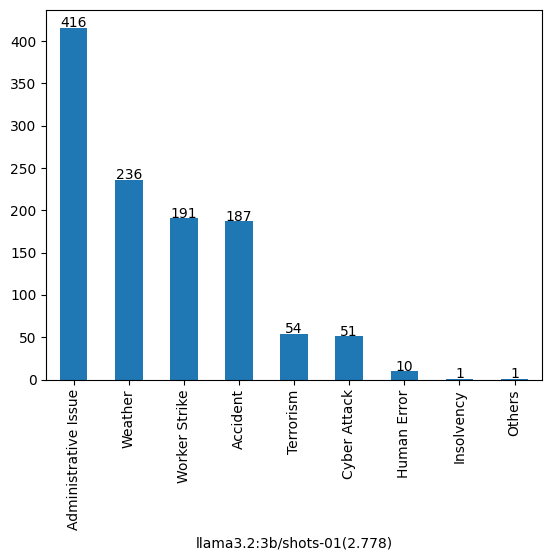

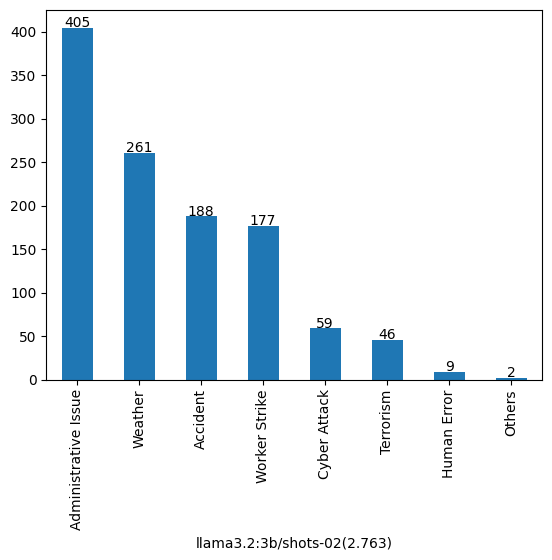

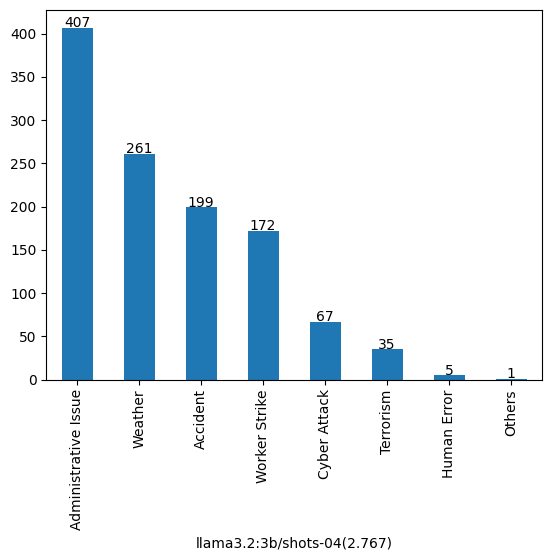

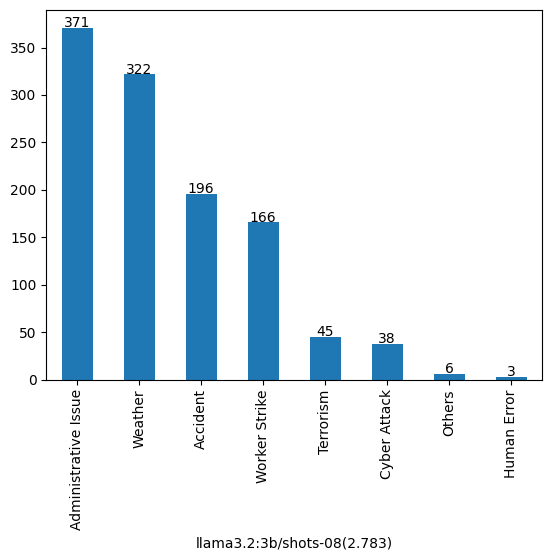

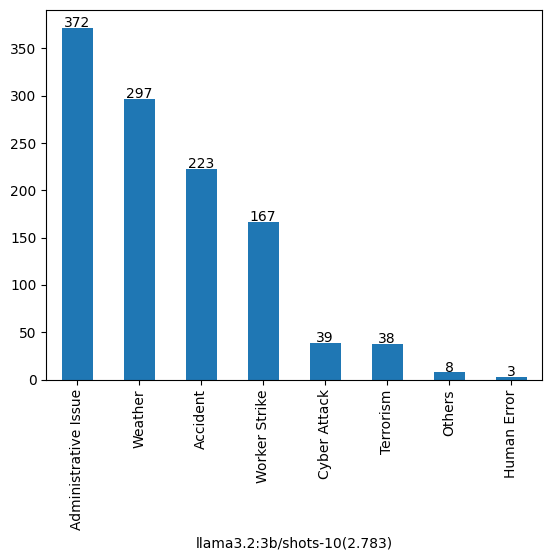

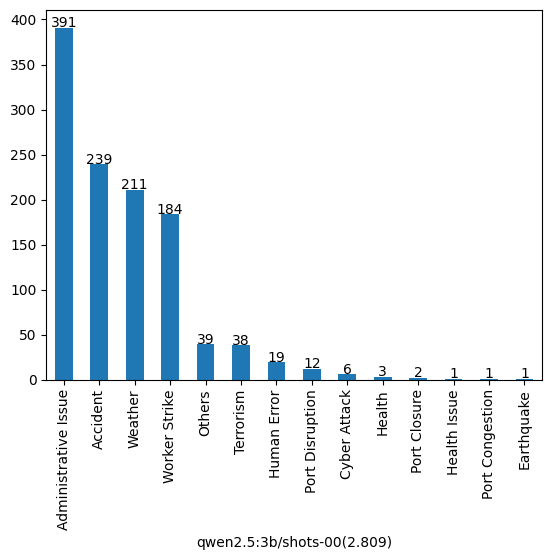

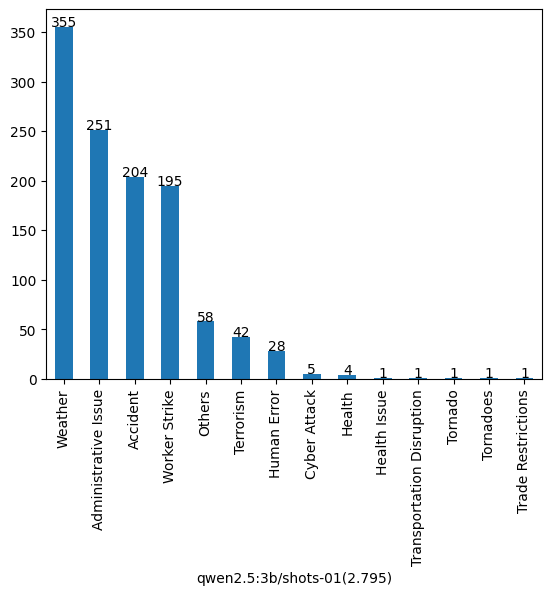

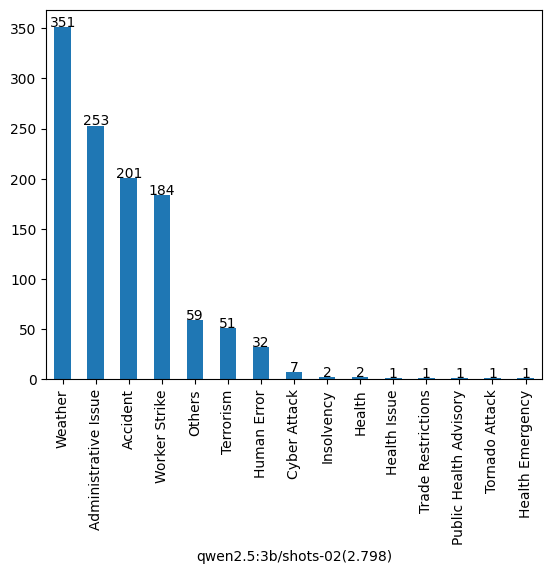

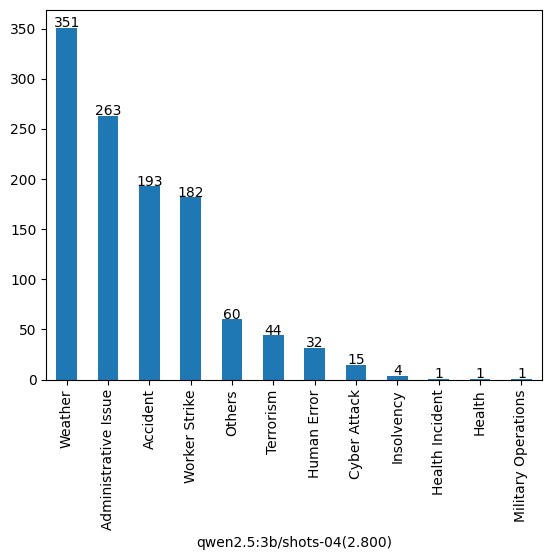

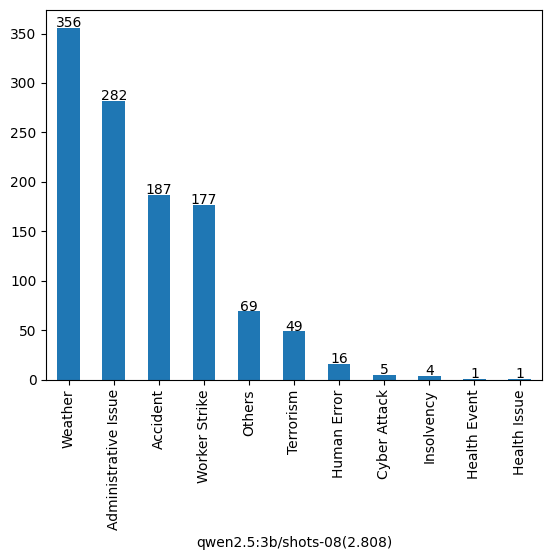

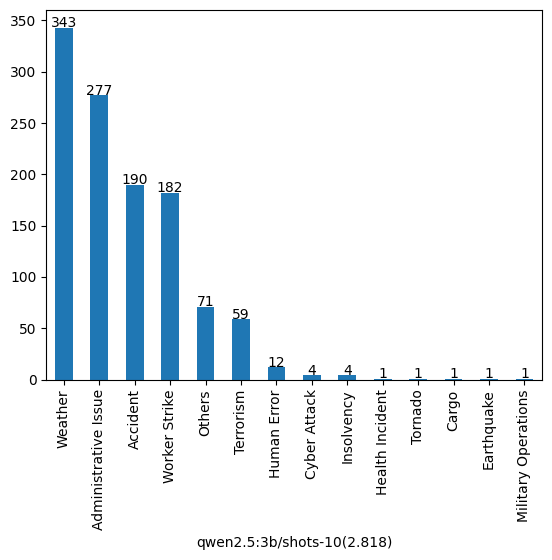

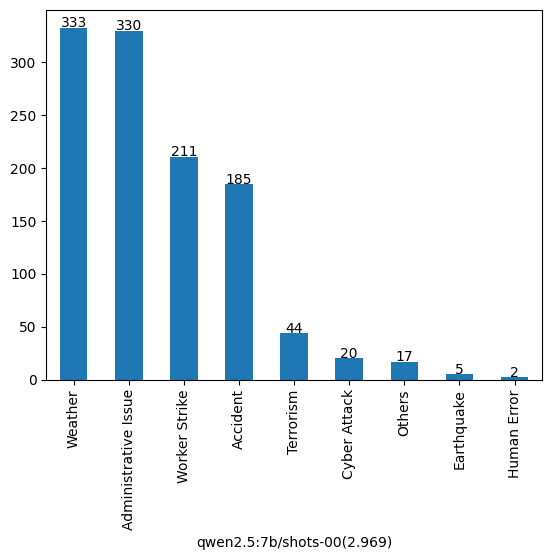

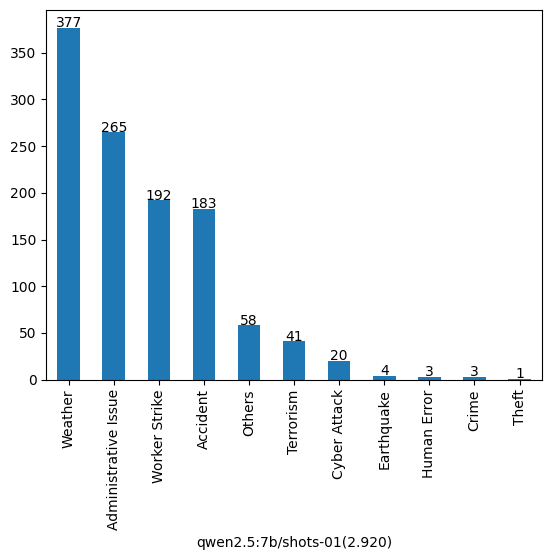

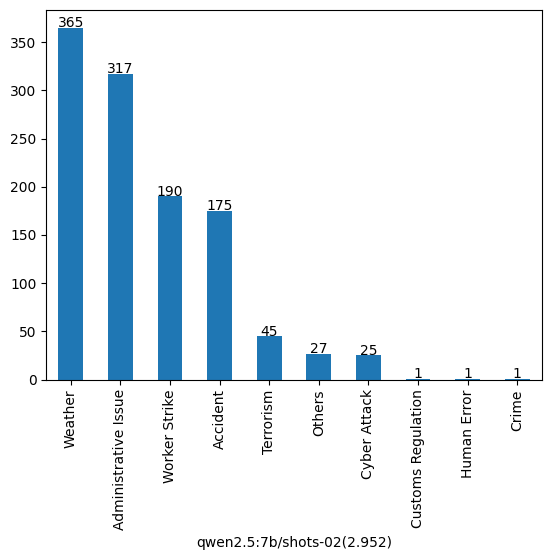

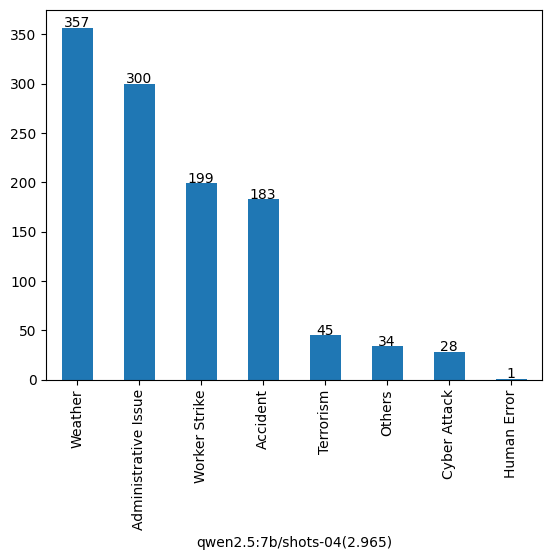

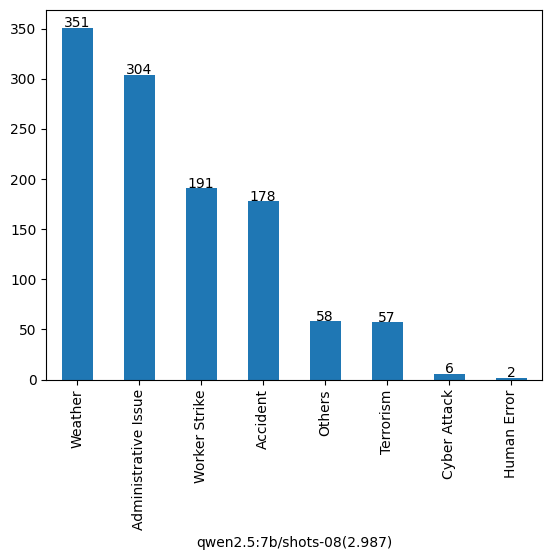

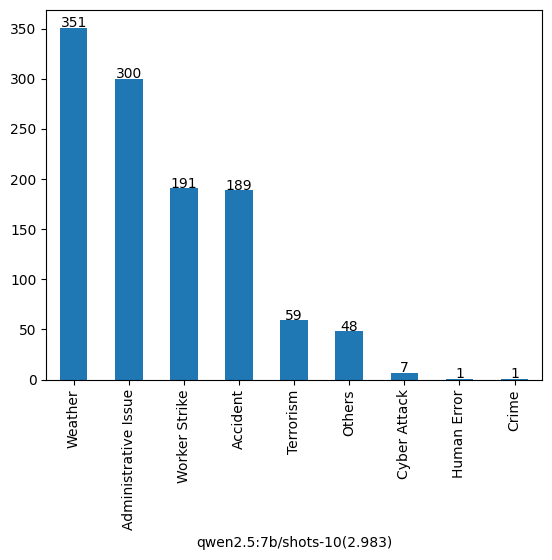

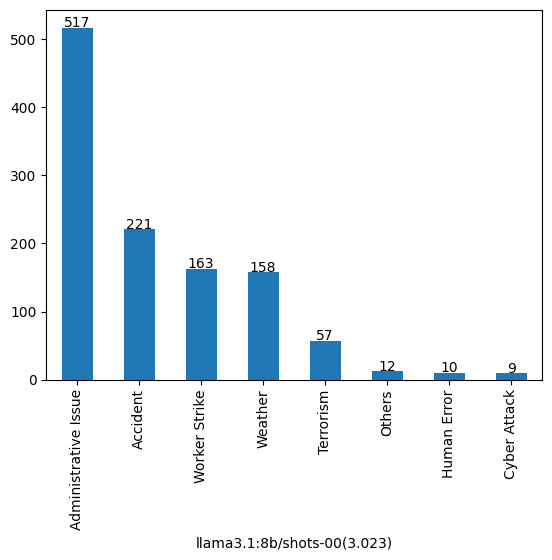

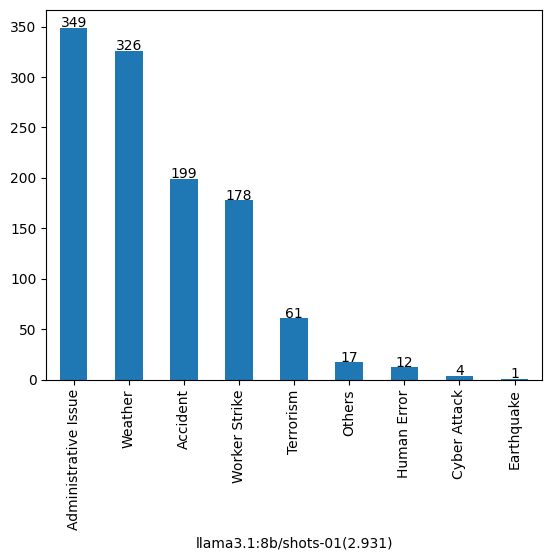

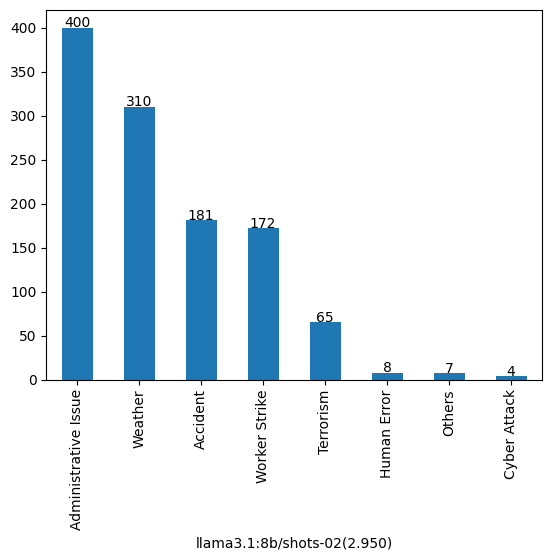

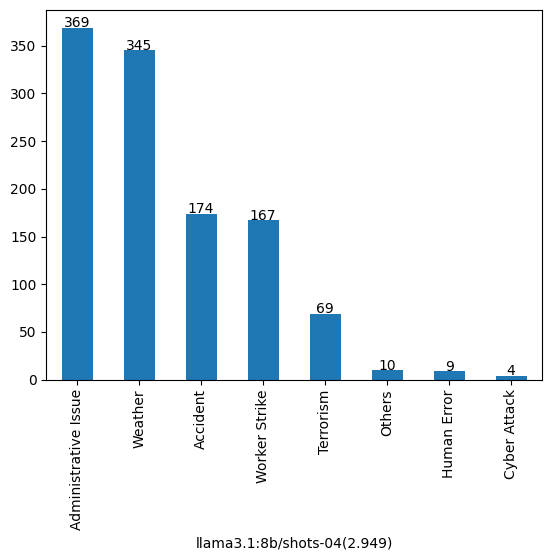

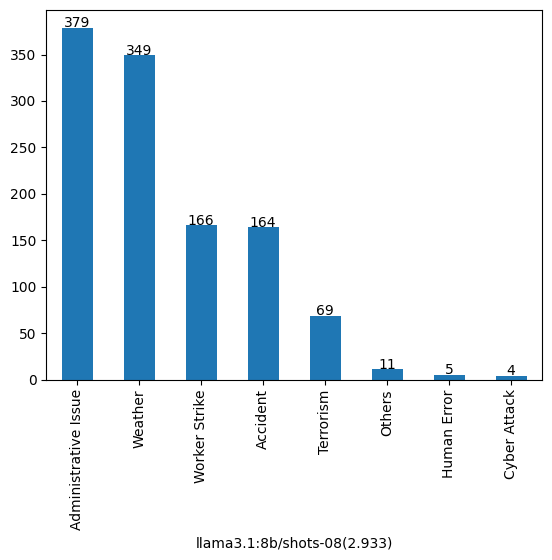

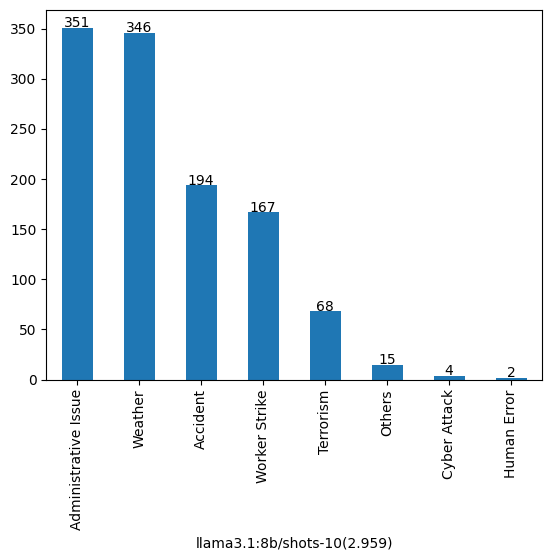

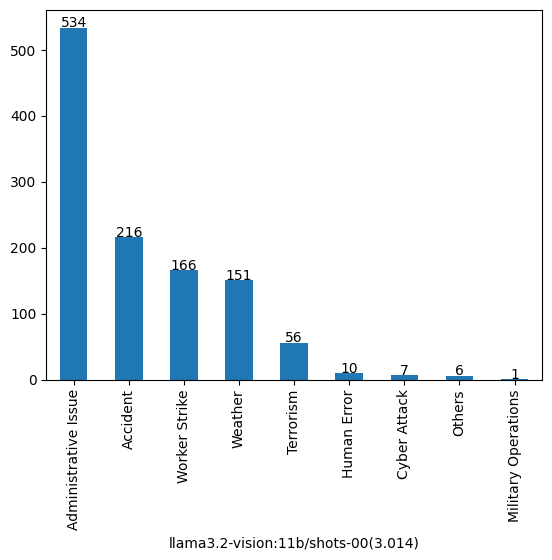

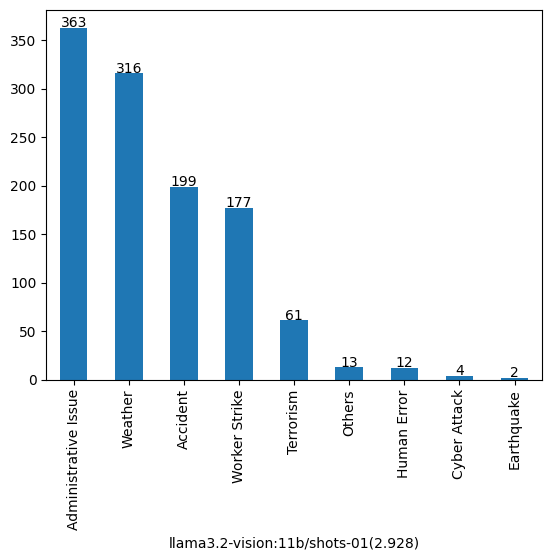

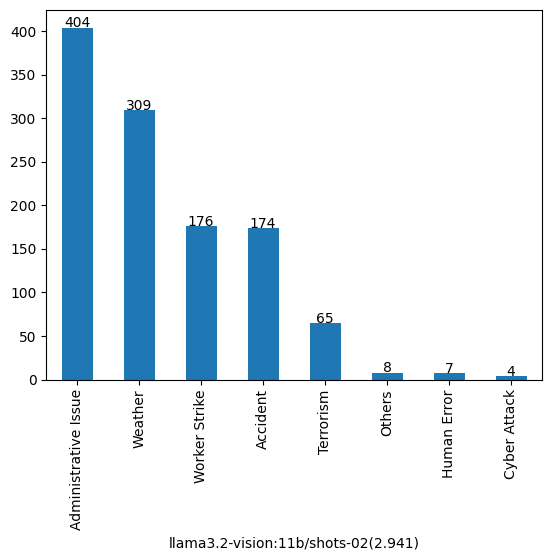

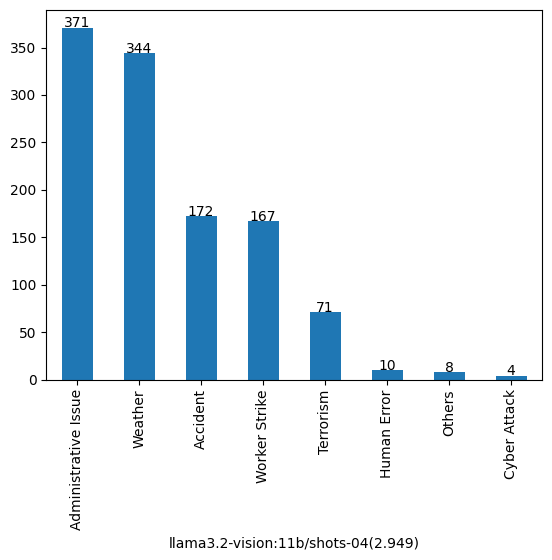

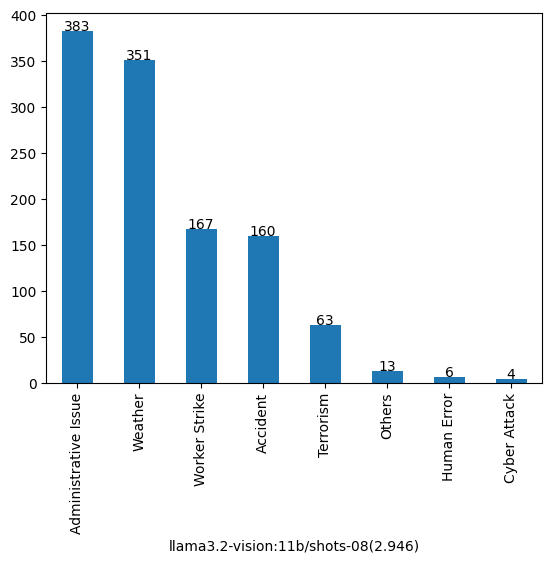

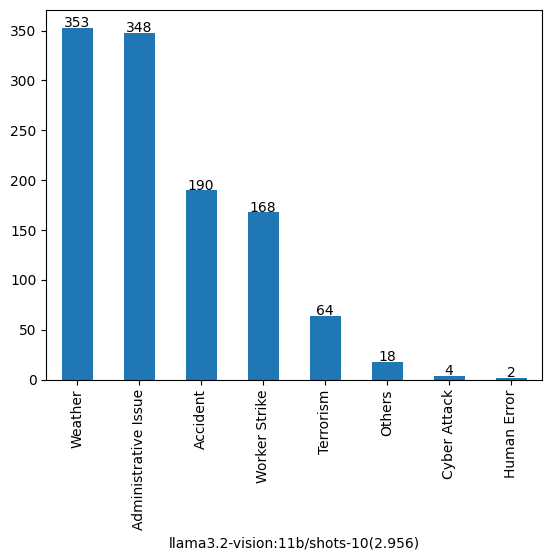

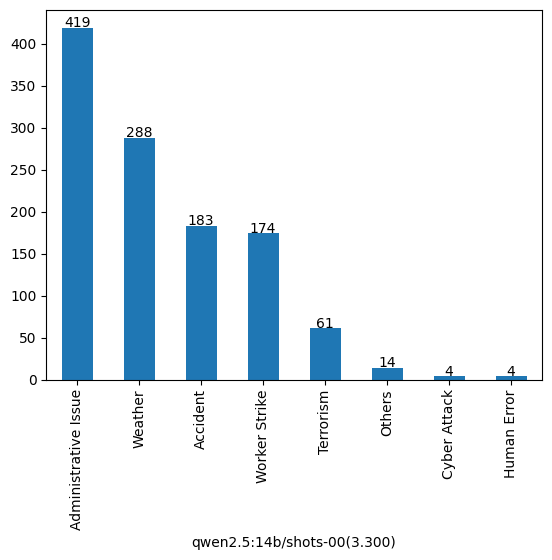

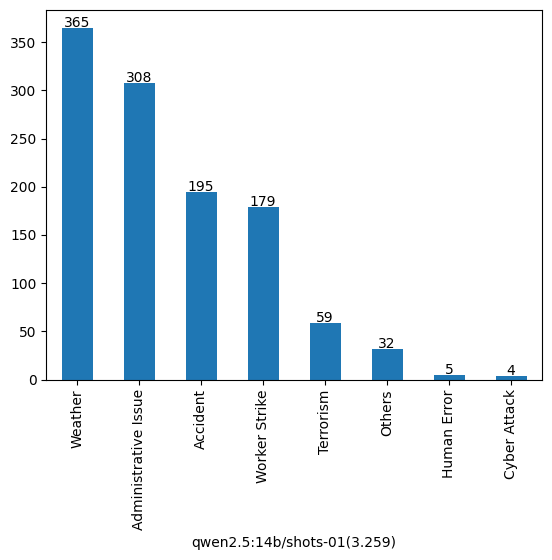

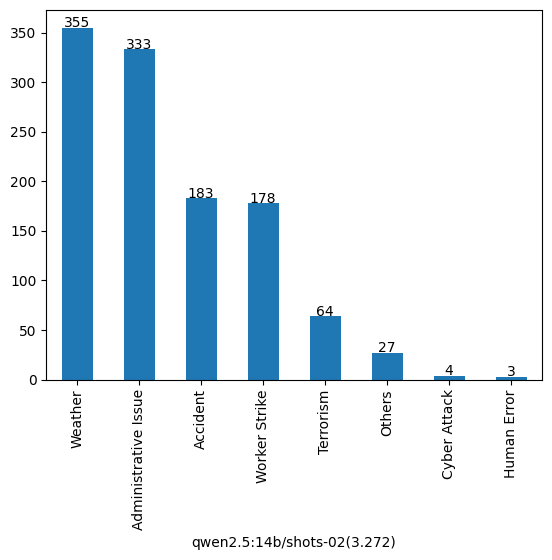

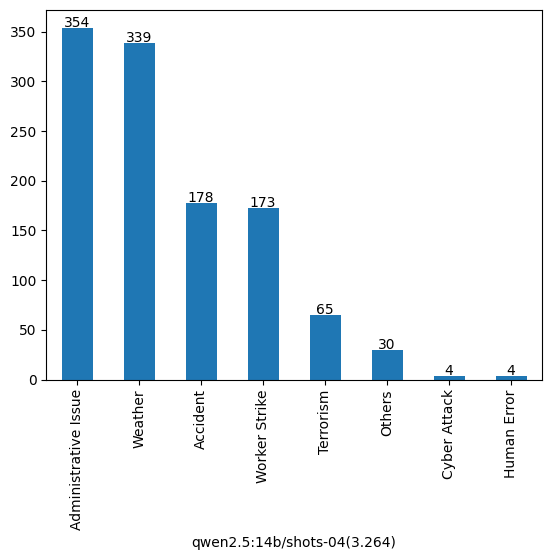

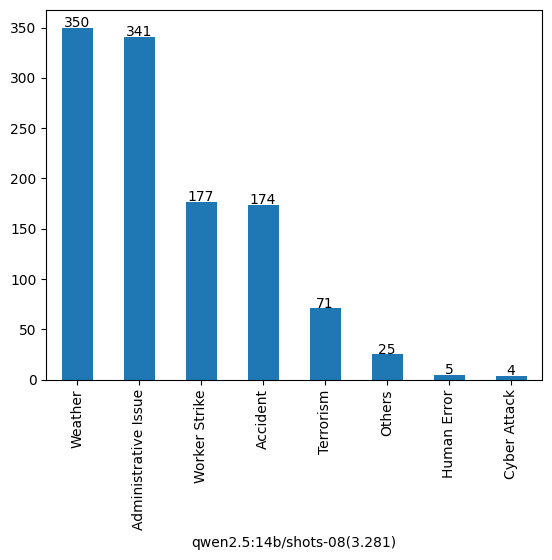

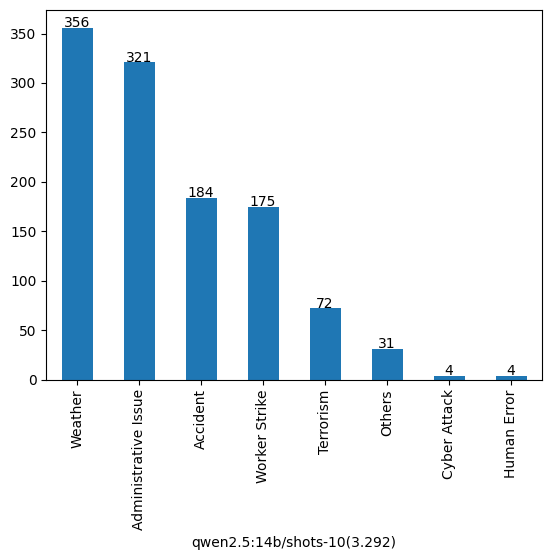

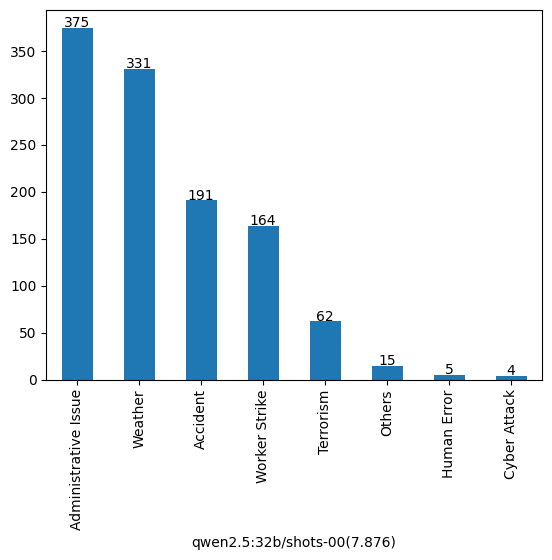

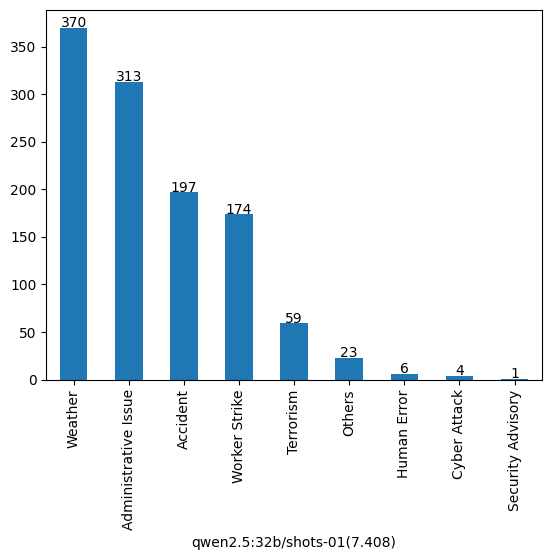

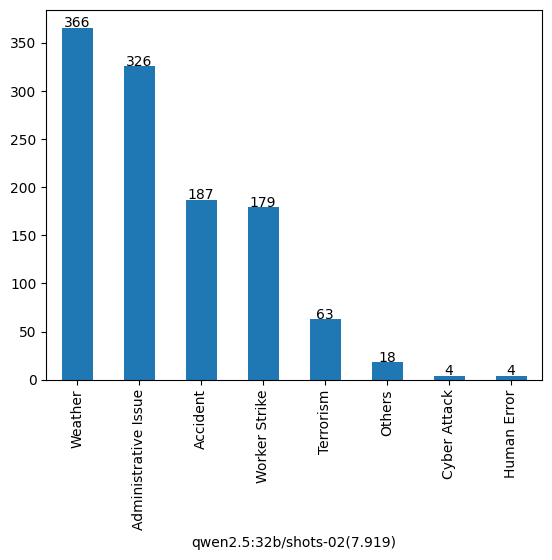

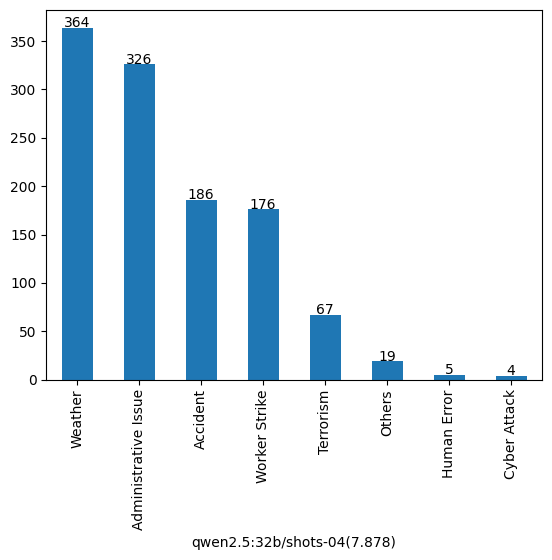

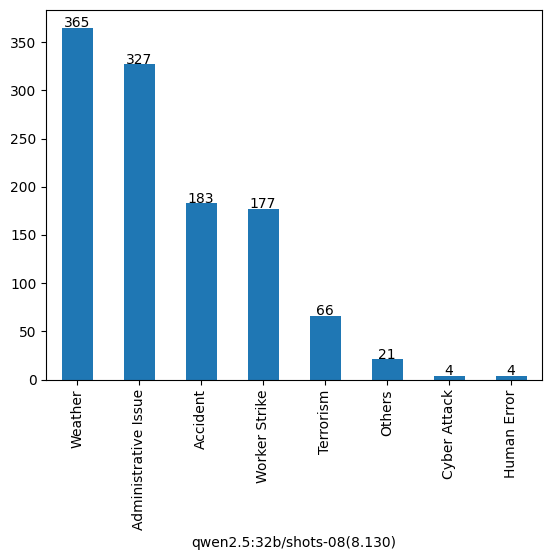

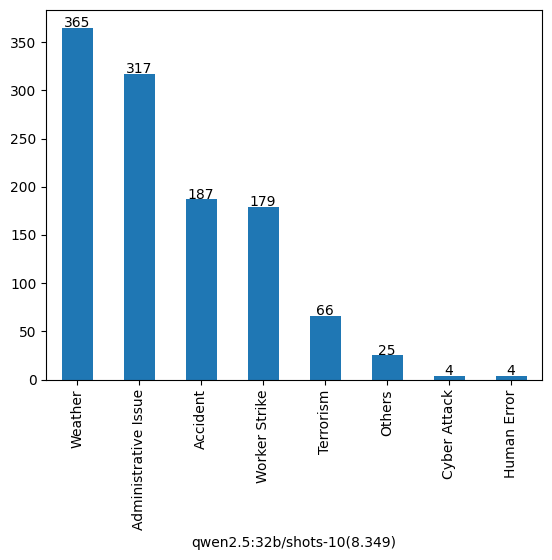

In [120]:
from llm_toolkit.data_utils import plot_bar_chart, extract_answer

for column in result_columns:
    plot_bar_chart(df, column, preprocess_func=extract_answer)